In [2]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
#import data
df = pd.read_csv(r'C:\Users\mansg\Documents\Big Data\Big_Data_EXAM2025\Data\Cancer2025exam.csv')

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier


In [3]:

#load data
y = df.iloc[:, 0]
X = df.iloc[:, 1:]
print(X.shape)
label_counts = y.value_counts()
print(label_counts.sort_index())


(1715, 201)
V1
1    363
2    285
3    266
4    195
5    231
6    170
7    205
Name: count, dtype: int64


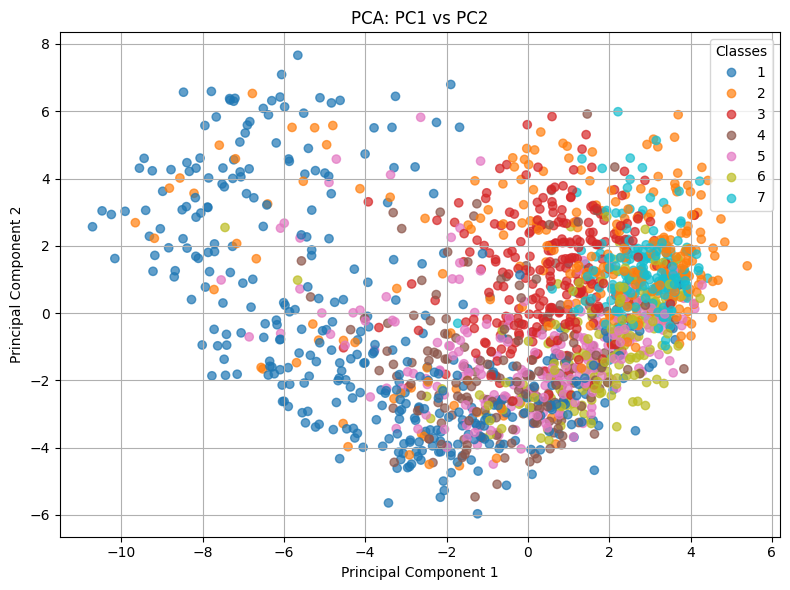

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Extract PC1 and PC2
pc1 = X_pca[:, 0]
pc2 = X_pca[:, 1]

# Plot PC1 vs PC2
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pc1, pc2, c=y, cmap='tab10', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: PC1 vs PC2')
plt.grid(True)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.tight_layout()
plt.show()


QUESTION 1a

In [45]:
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1715, 201)
y shape: (1715,)


In [46]:
models = {
    "KNN": (KNeighborsClassifier(), {
        'clf__n_neighbors': [i for i in range(1, 41, 4)],
        'clf__metric': ['minkowski', 'euclidean', 'manhattan']
    }),
    
    "LDA": (LinearDiscriminantAnalysis(), {
    }),
    
    "LogReg": (LogisticRegression(max_iter=1000), {
        'clf__C': [0.01, 0.1, 1, 10],
    }),
    
    "RandomForest": (RandomForestClassifier(), {
        'clf__n_estimators': [200, 300],
        'clf__max_depth': [20, 30, 40],
    }),
    
    "SVM": (SVC(probability=True), {
        'clf__C': [0.1, 1, 5, 10],
    }),
    
    "MLP": (MLPClassifier(max_iter=1000), {
        'clf__hidden_layer_sizes': [(50,), (100,),(150,)],
        'clf__alpha': [0.001, 0.01],
    })
}

In [ ]:
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

#how many train/test splits to run
repeats = 5

#declare variables to store important information: test acc, best params and confusion matrix values
test_accuracies = {name: [] for name in models.keys()}
best_params_across_runs = {name: [] for name in models.keys()}
conf_matrix_sums = {name: np.zeros((len(np.unique(y)), len(np.unique(y))), dtype=int) for name in models.keys()}
run_metrics = {name: [] for name in models.keys()}
proba_outputs = {name: [] for name in models.keys()}
confidence_stats = {name: {'confident_ratio': [], 'confident_wrong_preds': []} for name in models.keys()}
class_confidences = {name: {label: [] for label in np.unique(y)} for name in models.keys()}

#Outer loop for test/train splits
for i in range(repeats):
    print(f"\nRepetition {i+1}/{repeats}")
    
    #split data with stratified sampling into 20% test and 80% train
    all_indices = np.arange(len(X))
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, all_indices, test_size=0.2, stratify=y)
    
    #Inner loop with 10-fold CV
    for name, (clf, param_grid) in models.items():

        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', clf)
        ])
        
        grid = GridSearchCV(pipe, param_grid, cv=10, n_jobs=-1, scoring='accuracy')
        grid.fit(X_train, y_train)

        #compute metrics
        y_pred = grid.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        train_acc = accuracy_score(y_train, grid.predict(X_train))
        best_cv_score = grid.best_score_

        #store metrics
        test_accuracies[name].append(acc)
        best_params_across_runs[name].append(grid.best_params_)

        #update confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        conf_matrix_sums[name] += cm

        #sensitivity and specificity
        sensitivities = []
        specificities = []
        for i in range(len(cm)):
            TP = cm[i, i]
            FN = cm[i, :].sum() - TP
            FP = cm[:, i].sum() - TP
            TN = cm.sum() - (TP + FN + FP)
            
            sensitivity = TP / (TP + FN) if TP + FN > 0 else 0
            specificity = TN / (TN + FP) if TN + FP > 0 else 0

            sensitivities.append(sensitivity)
            specificities.append(specificity)

        avg_sensitivity = np.mean(sensitivities)
        avg_specificity = np.mean(specificities)

        run_metrics[name].append({
            'train_acc': train_acc,
            'test_acc': acc,
            'cv_acc': best_cv_score,
            'best_params': grid.best_params_,
            'sensitivities' : sensitivities,
            'specificities' : specificities,
            'avg_sens' : avg_sensitivity,
            'avg_spec' : avg_specificity
        })
        # confidence analysis
        if hasattr(grid.best_estimator_['clf'], "predict_proba"):
            y_proba = grid.predict_proba(X_test)
            confidences = np.max(y_proba, axis=1)

            confident_mask = confidences>= 0.75
            confident_ratio = np.mean(confident_mask)
            # Confident and correct predictions
            confident_correct_mask = (confidences >= 0.75) & (y_pred == y_test)
            confident_correct_ratio = np.mean(confident_correct_mask)

            if 'confident_correct_ratio' not in confidence_stats[name]:
                confidence_stats[name]['confident_correct_ratio'] = []
            confidence_stats[name]['confident_correct_ratio'].append(confident_correct_ratio)

            #class confidences
            for label in np.unique(y):
                label_mask = (y_test == label)
                
                label_conf = np.max(y_proba[label_mask], axis=1)
                
                class_confidences[name][label].extend(label_conf)

                
            high_conf_mask = confidences>= 0.9

            high_conf_wrong = ((y_pred != y_test) & high_conf_mask)

            num_strong_classes = np.sum(y_proba > 0.3, axis=1)
            ambiguous_mask = num_strong_classes >= 2
            
            #save probability and error data
            proba_outputs[name].append(y_proba)
            confidence_stats[name]['confident_ratio'].append(confident_ratio)
            confidence_stats[name]['confident_wrong_preds'].append(high_conf_wrong.sum())

            if 'confident_errors' not in confidence_stats[name]:
                confidence_stats[name]['confident_errors'] = []
            confidence_stats[name]['confident_errors'].append({
                'indices': idx_test[high_conf_wrong],
                'true_labels': y_test[high_conf_wrong],
                'pred_labels': y_pred[high_conf_wrong],
                'confidences': confidences[high_conf_wrong]
            })
            
            if 'ambiguous_predictions' not in confidence_stats[name]:
                confidence_stats[name]['ambiguous_predictions'] = []

            confidence_stats[name]['ambiguous_predictions'].append({
                'indices': idx_test[ambiguous_mask],
                'true_labels': y_test[ambiguous_mask],
                'pred_labels': y_pred[ambiguous_mask],
                'confidences': np.max(y_proba, axis=1)[ambiguous_mask],
                'num_strong_classes': num_strong_classes[ambiguous_mask],
                'full_proba': y_proba[ambiguous_mask]
            })

        else:
            print(f"{name} does not support predict_proba — skipping confidence analysis.")

        print(f"{name}: {acc:.4f}")


Repetition 1/5
KNN: 0.8192
LDA: 0.8222
LogReg: 0.8338
RandomForest: 0.8601
SVM: 0.8426
MLP: 0.7988

Repetition 2/5
KNN: 0.7988
LDA: 0.7901
LogReg: 0.7901
RandomForest: 0.8659
SVM: 0.8280
MLP: 0.7551

Repetition 3/5
KNN: 0.8163
LDA: 0.8134
LogReg: 0.8134
RandomForest: 0.8542
SVM: 0.8426
MLP: 0.7930

Repetition 4/5
KNN: 0.7901
LDA: 0.8105
LogReg: 0.8338
RandomForest: 0.8834
SVM: 0.8571
MLP: 0.8192

Repetition 5/5
KNN: 0.8251
LDA: 0.7901
LogReg: 0.8076
RandomForest: 0.8571
SVM: 0.8426
MLP: 0.7784


In [48]:
# Summary DataFrame
summary_rows = []

for name, metrics in run_metrics.items():
    df = pd.DataFrame(metrics)
    summary_rows.append({
        'Model': name,
        'Train Acc (mean)': df['train_acc'].mean(),
        'Test Acc (mean)': df['test_acc'].mean(),
        'CV Acc (mean)': df['cv_acc'].mean(),
        'Avg Sensitivity': df['avg_sens'].mean(),
        'Avg Specificity': df['avg_spec'].mean()
    })

summary_df = pd.DataFrame(summary_rows).sort_values(by='Test Acc (mean)', ascending=False)

print(summary_df.round(4))

          Model  Train Acc (mean)  Test Acc (mean)  CV Acc (mean)  \
3  RandomForest            1.0000           0.8641         0.8631   
4           SVM            0.9952           0.8426         0.8449   
2        LogReg            0.9115           0.8157         0.8127   
0           KNN            0.8254           0.8099         0.8044   
1           LDA            0.9017           0.8052         0.8038   
5           MLP            1.0000           0.7889         0.8022   

   Avg Sensitivity  Avg Specificity  
3           0.8534           0.9767  
4           0.8326           0.9732  
2           0.8083           0.9688  
0           0.7956           0.9676  
1           0.7976           0.9670  
5           0.7830           0.9643  


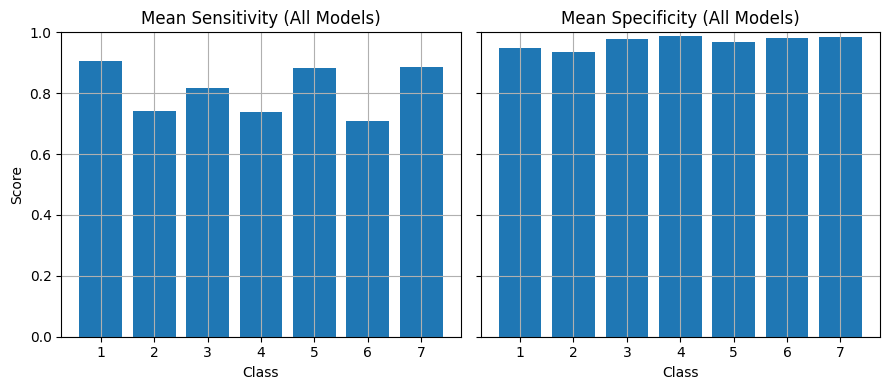

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# Accumulators for all sensitivities and specificities
all_sensitivities = []
all_specificities = []

for name in run_metrics:
    per_class_sens = np.array([m['sensitivities'] for m in run_metrics[name]])
    per_class_spec = np.array([m['specificities'] for m in run_metrics[name]])
    
    all_sensitivities.append(per_class_sens)  # shape: (n_runs, n_classes)
    all_specificities.append(per_class_spec)

# Concatenate all model data along axis=0 (i.e., all runs from all models)
all_sensitivities = np.concatenate(all_sensitivities, axis=0)  # shape: (total_runs, n_classes)
all_specificities = np.concatenate(all_specificities, axis=0)

# Compute mean across all runs/models
mean_sens_per_class = all_sensitivities.mean(axis=0)
mean_spec_per_class = all_specificities.mean(axis=0)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(9, 4), sharey=True)

# Sensitivity
axes[0].bar(range(len(mean_sens_per_class)), mean_sens_per_class)
axes[0].set_xticks(range(len(mean_sens_per_class)))
axes[0].set_xticklabels([f'{i+1}' for i in range(len(mean_sens_per_class))])
axes[0].set_ylabel("Score")
axes[0].set_title("Mean Sensitivity (All Models)")
axes[0].set_ylim(0, 1)
axes[0].set_xlabel("Class")
axes[0].grid(True)

# Specificity
axes[1].bar(range(len(mean_spec_per_class)), mean_spec_per_class)
axes[1].set_xticks(range(len(mean_spec_per_class)))
axes[1].set_xticklabels([f'{i+1}' for i in range(len(mean_spec_per_class))])
axes[1].set_title("Mean Specificity (All Models)")
axes[1].set_ylim(0, 1)
axes[1].set_xlabel("Class")
axes[1].grid(True)

plt.tight_layout()
plt.show()


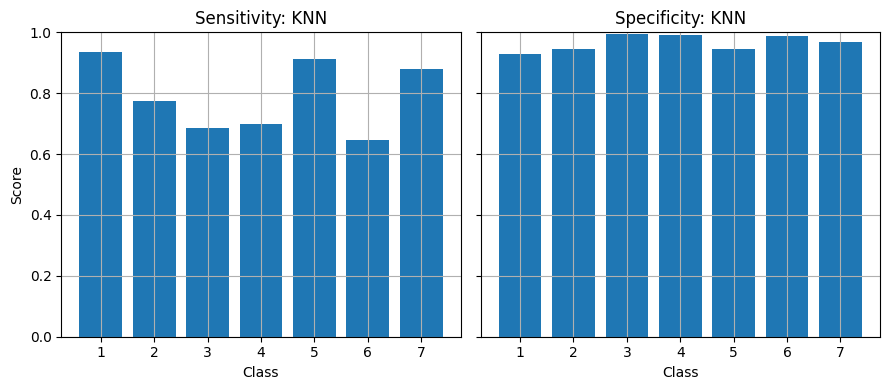

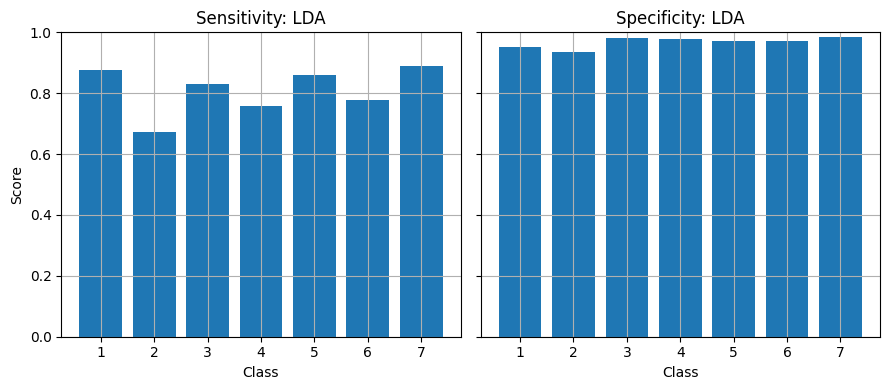

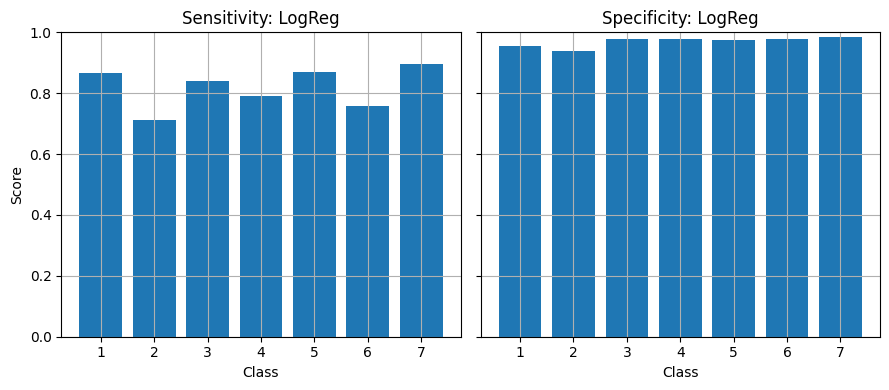

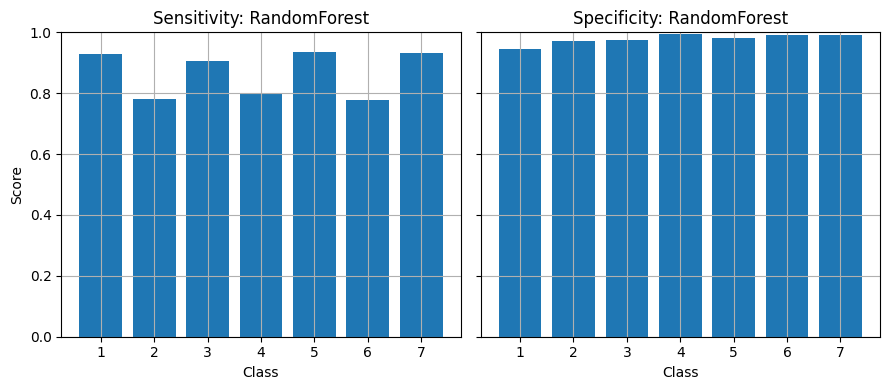

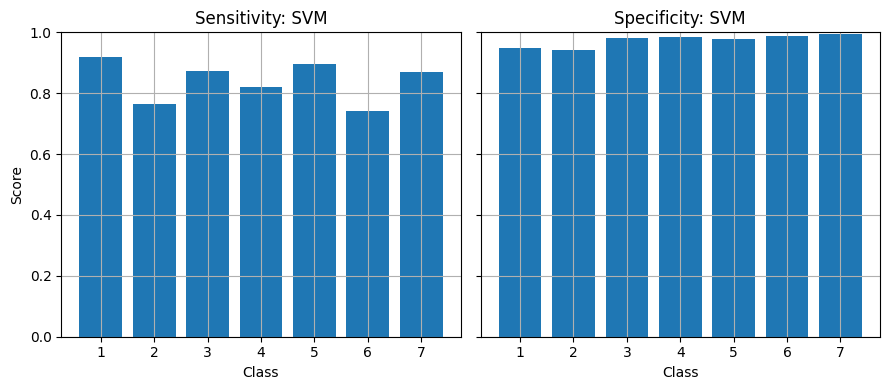

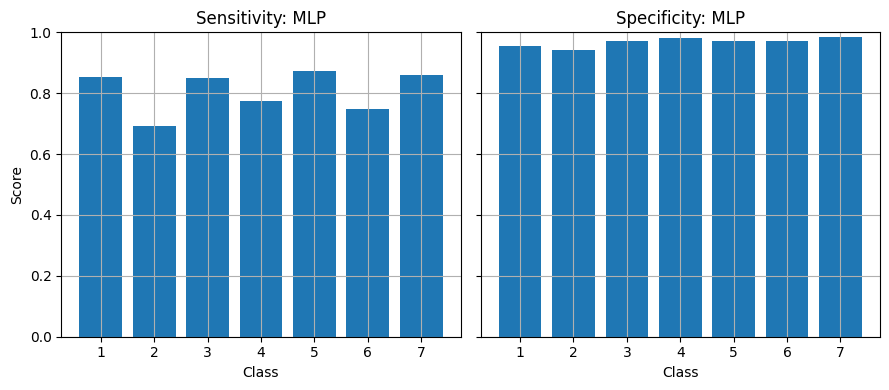

In [11]:
import matplotlib.pyplot as plt
import numpy as np

for name in run_metrics:
    per_class_sens = np.array([m['sensitivities'] for m in run_metrics[name]])
    mean_sens_per_class = per_class_sens.mean(axis=0)

    per_class_spec = np.array([m['specificities'] for m in run_metrics[name]])
    mean_spec_per_class = per_class_spec.mean(axis=0)

    fig, axes = plt.subplots(1, 2, figsize=(9, 4), sharey=True)

    #sensitivity plot
    axes[0].bar(range(len(mean_sens_per_class)), mean_sens_per_class)
    axes[0].set_xticks(range(len(mean_sens_per_class)))
    axes[0].set_xticklabels([f'{i+1}' for i in range(len(mean_sens_per_class))])
    axes[0].set_ylabel("Score")
    axes[0].set_title(f"Sensitivity: {name}")
    axes[0].set_ylim(0, 1)
    axes[0].set_xlabel('Class')
    axes[0].grid(True)

    #specificity plot
    axes[1].bar(range(len(mean_spec_per_class)), mean_spec_per_class)
    axes[1].set_xticks(range(len(mean_spec_per_class)))
    axes[1].set_xticklabels([f'{i+1}' for i in range(len(mean_spec_per_class))])
    axes[1].set_title(f"Specificity: {name}")
    axes[1].set_ylim(0, 1)
    axes[1].set_xlabel('Class')
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()



KNN Best Parameters Across Runs:
  Run 1: {'clf__metric': 'manhattan', 'clf__n_neighbors': 29}
  Run 2: {'clf__metric': 'manhattan', 'clf__n_neighbors': 33}
  Run 3: {'clf__metric': 'manhattan', 'clf__n_neighbors': 29}
  Run 4: {'clf__metric': 'manhattan', 'clf__n_neighbors': 21}
  Run 5: {'clf__metric': 'manhattan', 'clf__n_neighbors': 29}

LDA Best Parameters Across Runs:
  Run 1: {}
  Run 2: {}
  Run 3: {}
  Run 4: {}
  Run 5: {}

LogReg Best Parameters Across Runs:
  Run 1: {'clf__C': 0.01}
  Run 2: {'clf__C': 0.01}
  Run 3: {'clf__C': 0.01}
  Run 4: {'clf__C': 0.01}
  Run 5: {'clf__C': 0.01}

RandomForest Best Parameters Across Runs:
  Run 1: {'clf__max_depth': 20, 'clf__n_estimators': 300}
  Run 2: {'clf__max_depth': 40, 'clf__n_estimators': 300}
  Run 3: {'clf__max_depth': 20, 'clf__n_estimators': 300}
  Run 4: {'clf__max_depth': 20, 'clf__n_estimators': 200}
  Run 5: {'clf__max_depth': 30, 'clf__n_estimators': 200}

SVM Best Parameters Across Runs:
  Run 1: {'clf__C': 5}
  Run

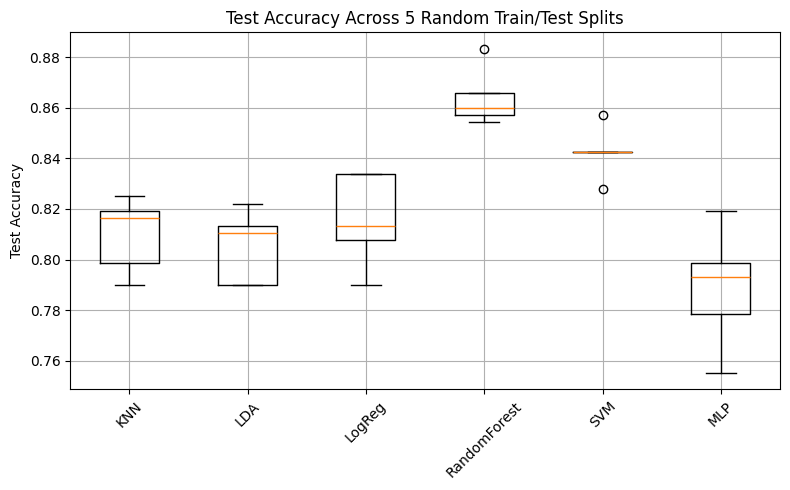

In [50]:
# Print best params for each model across all runs
for name, params_list in best_params_across_runs.items():
    print(f"\n{name} Best Parameters Across Runs:")
    for i, params in enumerate(params_list):
        print(f"  Run {i+1}: {params}")
        
plt.figure(figsize=(8, 5))
plt.boxplot([test_accuracies[name] for name in models.keys()], labels=models.keys())

plt.ylabel('Test Accuracy')
plt.title('Test Accuracy Across 5 Random Train/Test Splits')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

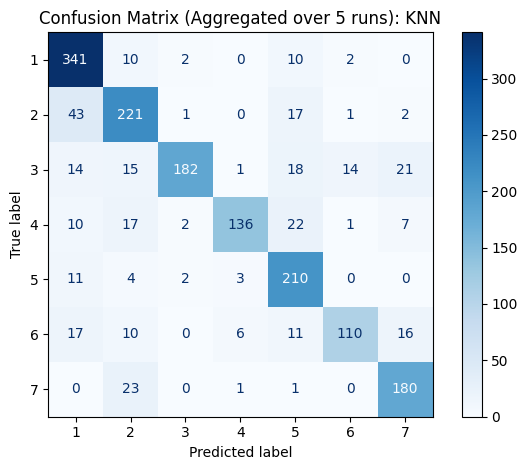

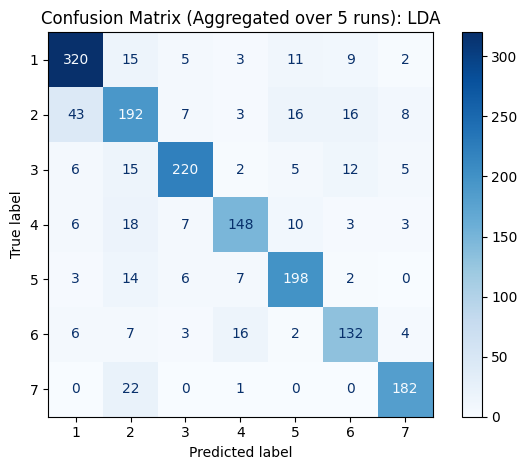

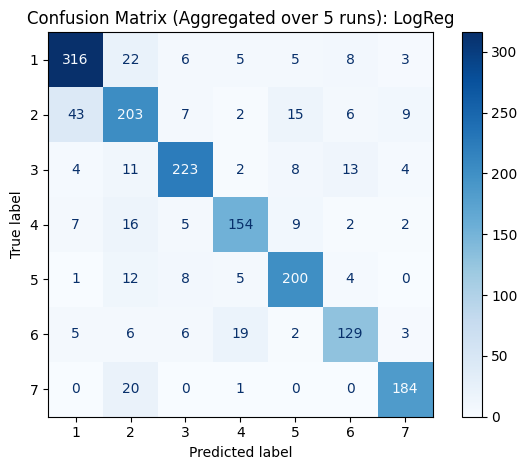

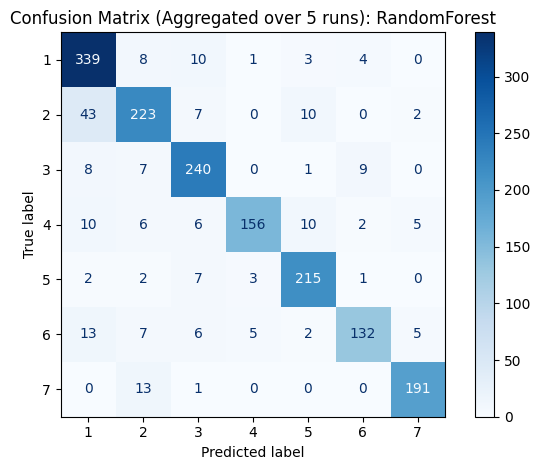

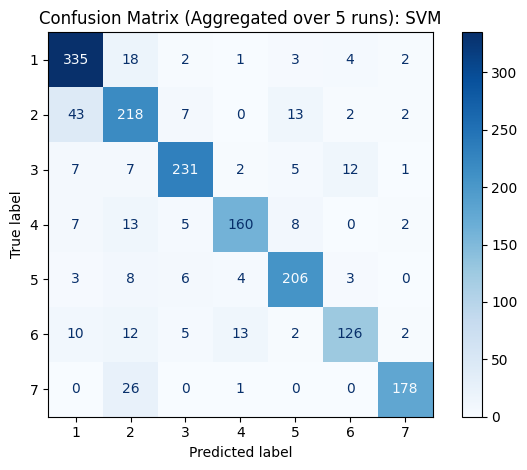

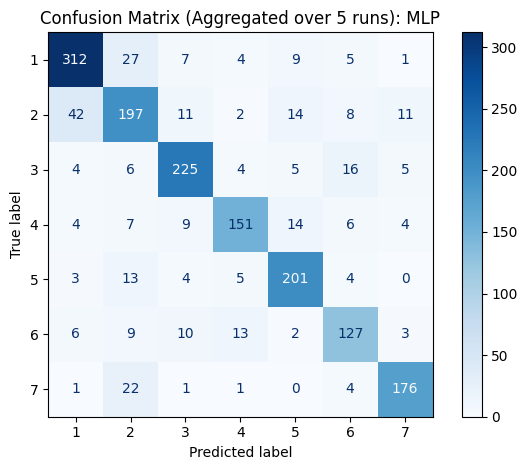

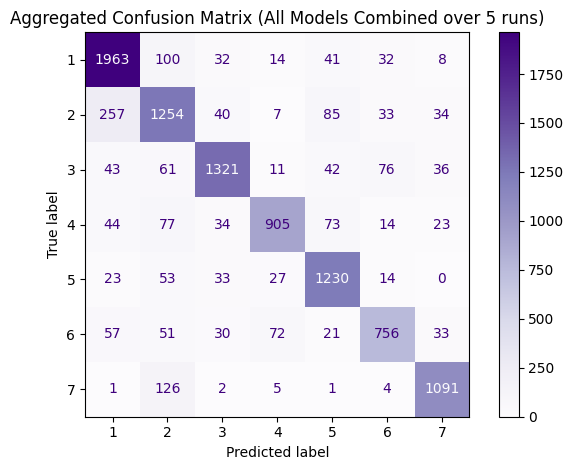

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

for name, cm_sum in conf_matrix_sums.items():
    num_classes = cm_sum.shape[0]
    class_labels = [f'{i+1}' for i in range(num_classes)]

    disp = ConfusionMatrixDisplay(confusion_matrix=cm_sum, display_labels=class_labels)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix (Aggregated over {repeats} runs): {name}')
    plt.tight_layout()
    plt.show()

total_cm = sum(conf_matrix_sums.values())

num_classes = total_cm.shape[0]
class_labels = [f'{i+1}' for i in range(num_classes)]

disp = ConfusionMatrixDisplay(confusion_matrix=total_cm, display_labels=class_labels)
disp.plot(cmap='Purples')
plt.title(f'Aggregated Confusion Matrix (All Models Combined over {repeats} runs)')
plt.tight_layout()
plt.show()

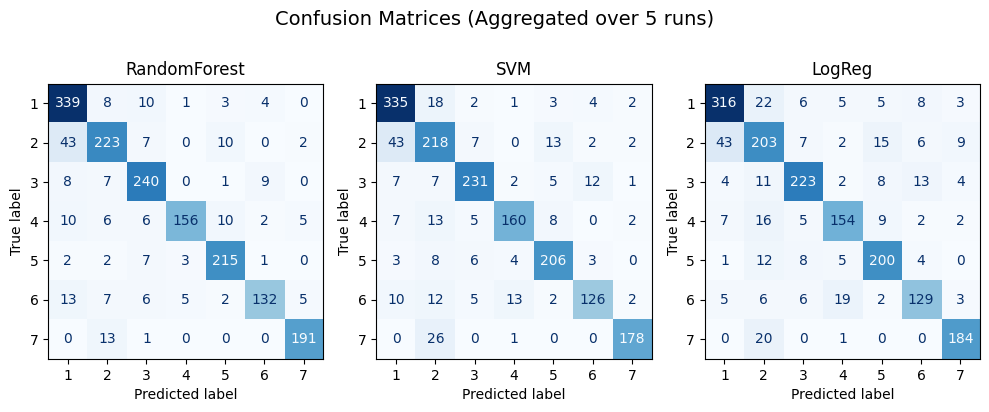

In [14]:
# Choose the models to plot
models_to_plot = ['RandomForest', 'SVM', 'LogReg']

# Set up subplots: 1 row, 3 columns
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

# Loop through each selected model and plot its confusion matrix
for ax, model_name in zip(axes, models_to_plot):
    cm = conf_matrix_sums[model_name]
    num_classes = cm.shape[0]
    class_labels = [f'{i+1}' for i in range(num_classes)]

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap='Blues', ax=ax, colorbar=False)
    ax.set_title(f'{model_name}')

# Add a main title and tighten layout
plt.suptitle(f'Confusion Matrices (Aggregated over {repeats} runs)', fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave room for suptitle
plt.show()

QUESTION 1b

In [51]:
print("\nConfidence Summary (Threshold ≥ 0.7):")
for name in models:
    ratios = confidence_stats[name].get('confident_ratio', [])
    correct_ratios = confidence_stats[name].get('confident_correct_ratio', [])

    if not ratios or not correct_ratios:
        print(f"{name}: (no data — skipped)")
        continue

    avg_confident = np.mean(ratios)
    avg_confident_correct = np.mean(correct_ratios)

    print(f"{name}:")
    print(f"  Avg Confident Predictions (≥0.7): {avg_confident:.2%}")
    print(f"  Avg Confident & Correct Predictions (≥0.7 & correct): {avg_confident_correct:.2%}")


Confidence Summary (Threshold ≥ 0.7):
KNN:
  Avg Confident Predictions (≥0.7): 26.53%
  Avg Confident & Correct Predictions (≥0.7 & correct): 24.90%
LDA:
  Avg Confident Predictions (≥0.7): 86.82%
  Avg Confident & Correct Predictions (≥0.7 & correct): 74.58%
LogReg:
  Avg Confident Predictions (≥0.7): 42.92%
  Avg Confident & Correct Predictions (≥0.7 & correct): 40.41%
RandomForest:
  Avg Confident Predictions (≥0.7): 13.88%
  Avg Confident & Correct Predictions (≥0.7 & correct): 13.47%
SVM:
  Avg Confident Predictions (≥0.7): 70.96%
  Avg Confident & Correct Predictions (≥0.7 & correct): 66.36%
MLP:
  Avg Confident Predictions (≥0.7): 82.86%
  Avg Confident & Correct Predictions (≥0.7 & correct): 71.37%


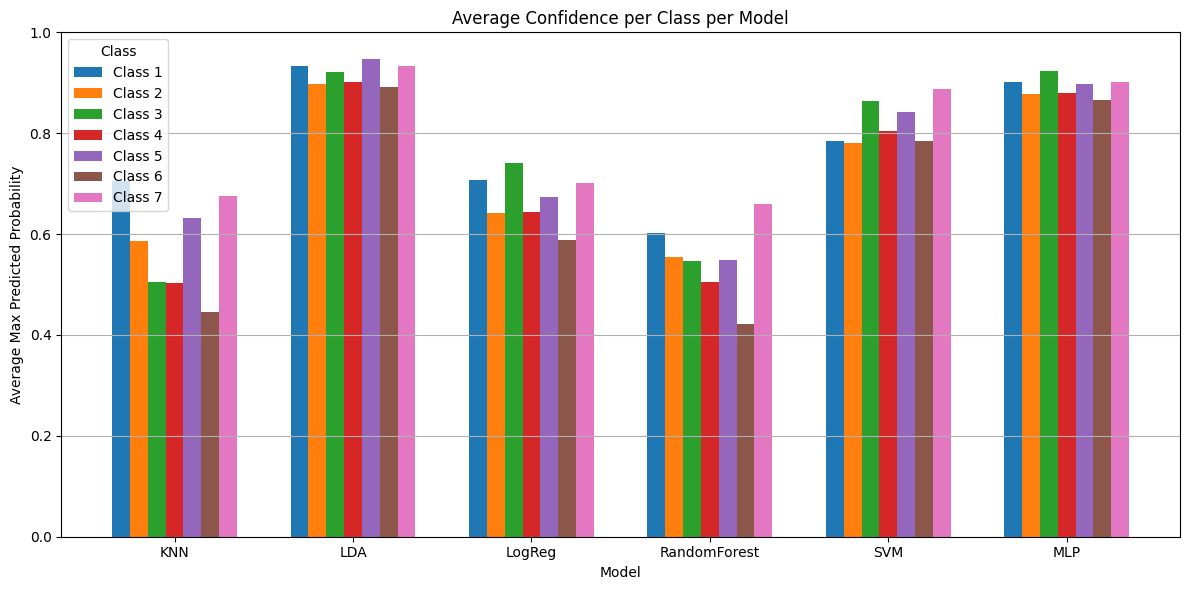

In [52]:
import numpy as np
import matplotlib.pyplot as plt

labels = sorted(np.unique(y))               # class labels
models_list = list(class_confidences.keys())  # model names
n_classes = len(labels)
n_models = len(models_list)

# Prepare matrix: avg_conf_matrix[class][model]
avg_conf_matrix = np.zeros((n_classes, n_models))

# Fill it
for i, class_label in enumerate(labels):
    for j, model in enumerate(models_list):
        confs = class_confidences[model][class_label]
        avg_conf_matrix[i, j] = np.mean(confs) if len(confs) > 0 else np.nan

# Plot with models on x-axis and grouped bars for each class
x = np.arange(n_models)
bar_width = 0.1
offset = (n_classes - 1) / 2 * bar_width  # center the bars

plt.figure(figsize=(12, 6))

for i in range(n_classes):
    plt.bar(
        x + (i - n_classes // 2) * bar_width,
        avg_conf_matrix[i],
        width=bar_width,
        label=f'Class {labels[i]}'
    )

plt.xticks(x, models_list)
plt.xlabel('Model')
plt.ylabel('Average Max Predicted Probability')
plt.title('Average Confidence per Class per Model')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.legend(title='Class')
plt.tight_layout()
plt.show()
         

In [53]:
from collections import defaultdict
import pandas as pd
import numpy as np

# Safely gather all high-confidence misclassifications across models and runs
confident_error_log = defaultdict(list)

for model_name in confidence_stats:
    for run_idx, err in enumerate(confidence_stats[model_name].get('confident_errors', [])):
        indices = np.array(err['indices'])
        true = np.array(err['true_labels'])
        pred = np.array(err['pred_labels'])
        confs = np.array(err['confidences'])

        # Loop through each misclassified observation in this run
        for idx_i, true_i, pred_i, conf_i in zip(indices, true, pred, confs):
            confident_error_log[idx_i].append({
                'model': model_name,
                'run': run_idx + 1,
                'true_class': true_i,
                'pred_class': pred_i,
                'confidence': round(conf_i, 3)
            })

# Now filter for observations misclassified by multiple models
multi_model_errors = {idx: entries for idx, entries in confident_error_log.items() if len(entries) > 1}

# Format into DataFrame
rows = []
for obs_idx, records in multi_model_errors.items():
    for r in records:
        rows.append({
            'Observation': obs_idx,
            'Model': r['model'],
            'Run': r['run'],
            'True Class': r['true_class'],
            'Predicted Class': r['pred_class'],
            'Confidence': r['confidence']
        })

df_errors = pd.DataFrame(rows)

# Sort for clarity
df_errors.sort_values(by=['True Class', 'Predicted Class', 'Observation'], inplace=True)

In [84]:
# Count how many times each observation appears
obs_counts = df_errors['Observation'].value_counts()

# Filter to only those with more than 3 appearances
obs_to_keep = obs_counts[obs_counts > 5].index

# Apply the filter to the dataframe
df_errors_filtered = df_errors[df_errors['Observation'].isin(obs_to_keep)]
df_errors_filtered
#df_errors_filtered[df_errors_filtered["True Class"]<=2]
#df_errors_filtered[df_errors_filtered["True Class"]>2]


,Observation,Model,Run,True Class,Predicted Class,Confidence
12,654,KNN,4,2,1,0.905
13,654,LDA,3,2,1,0.999
14,654,LDA,4,2,1,0.999
15,654,LogReg,4,2,1,0.919
16,654,SVM,3,2,1,0.940
17,654,SVM,4,2,1,0.940
18,654,MLP,3,2,1,0.999
19,654,MLP,4,2,1,1.000
132,1081,LDA,2,2,1,1.000
133,1081,LDA,5,2,1,1.000


In [85]:
# Display the filtered result
print(df_errors_filtered["Observation"].unique())
print(df_errors_filtered["True Class"].unique())
print(len(df_errors_filtered["Observation"].unique()))

[ 654 1081  898  407 1625  830  886]
[2 3 4 6 7]
7


In [65]:
rows = []

for model_name in confidence_stats:
    for run_idx, run_data in enumerate(confidence_stats[model_name].get('ambiguous_predictions', [])):
        indices = np.array(run_data['indices'])
        true_labels = np.array(run_data['true_labels'])
        pred_labels = np.array(run_data['pred_labels'])
        confidences = np.array(run_data['confidences'])
        proba = np.array(run_data['full_proba'])

        for i in range(len(indices)):
            row = {
                'Run': run_idx + 1,
                'Model': model_name,
                'Observation': indices[i],
                'True Class': true_labels[i],
                'Predicted Class': pred_labels[i],
                'Confidence (Max)': round(confidences[i], 3)
            }

            for class_idx, class_prob in enumerate(proba[i]):
                row[f'Class_{class_idx}'] = round(class_prob, 3)

            rows.append(row)

df_ambiguous = pd.DataFrame(rows)
df_ambiguous.sort_values(by=['Observation', 'True Class','Model', 'Run'], inplace=True)

In [80]:
amb_obs_counts = df_ambiguous['Observation'].value_counts()

amb_obs_to_keep = amb_obs_counts[amb_obs_counts > 6].index
df_amb_filtered = df_ambiguous[df_ambiguous['Observation'].isin(amb_obs_to_keep)]
print(df_amb_filtered[df_amb_filtered["Observation"]>1000])
#print(df_amb_filtered)


     Run         Model  Observation  True Class  Predicted Class  \
114    3           KNN         1025           1                1   
164    5           KNN         1025           1                1   
296    5           LDA         1025           1                2   
395    3        LogReg         1025           1                1   
446    5        LogReg         1025           1                2   
620    3           SVM         1025           1                1   
663    5           SVM         1025           1                1   
70     2           KNN         1080           2                2   
143    4           KNN         1080           2                2   
371    2        LogReg         1080           2                2   
419    4        LogReg         1080           2                2   
746    2           MLP         1080           2                7   
494    2  RandomForest         1080           2                2   
518    4  RandomForest         1080           2 

In [86]:
print(len(df_amb_filtered["Observation"].unique()))
print(df_amb_filtered["Observation"].unique())

13
[ 182  204  220  236  820  925 1025 1080 1213 1306 1319 1584 1668]


QUESTION 1C - FEATURE REDUCTION

In [87]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
import umap

# Define DR techniques
dr_methods = {
    "PCA": PCA(n_components=25),
    "UMAP": umap.UMAP(n_components=25),
    "SelectKBest": SelectKBest(score_func=f_classif, k=25)
}

In [88]:
models_dr = {
    "KNN": (KNeighborsClassifier(), {
        'clf__n_neighbors': [i for i in range(1, 40, 4)],
        'clf__metric': ['minkowski', 'euclidean', 'manhattan']
    }),
    
    
    "RandomForest": (RandomForestClassifier(), {
        'clf__n_estimators': [200, 300],
        'clf__max_depth': [20, 30, 40],
    }),
    
    "SVM": (SVC(probability=True), {
        'clf__C': [0.1, 1, 5, 10],
    }),
    
}

In [ ]:
#how many train/test splits to run
repeats = 5

# Storage for results
results = []
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

for dr_name, dr in dr_methods.items():
    for clf_name, (clf, param_grid) in models_dr.items():
        model_label = f"{dr_name} + {clf_name}"
        print(f"\n Running: {model_label}")
        
        acc_scores = []

        for i in range(repeats):
            # Split
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=i)

            X_train_dr = dr.fit_transform(X_train, y_train)
            X_test_dr = dr.transform(X_test)

            pipe = Pipeline([
                ('scaler', StandardScaler()),
                ('clf', clf)
            ])

            grid = GridSearchCV(pipe, param_grid, cv=10, scoring='accuracy', n_jobs=-1)
            grid.fit(X_train_dr, y_train)

            y_pred = grid.predict(X_test_dr)
            acc = accuracy_score(y_test, y_pred)
            acc_scores.append(acc)

            print(f"  Run {i+1}/{repeats} | {model_label} | Test Accuracy: {acc:.4f}")
        
        results.append({
            'Model': model_label,
            'Mean Accuracy': np.mean(acc_scores),
            'Std Accuracy': np.std(acc_scores),
            'All Accuracies': acc_scores
        })
        


 Running: PCA + KNN
  Run 1/5 | PCA + KNN | Test Accuracy: 0.7726
  Run 2/5 | PCA + KNN | Test Accuracy: 0.8017
  Run 3/5 | PCA + KNN | Test Accuracy: 0.7755
  Run 4/5 | PCA + KNN | Test Accuracy: 0.8163
  Run 5/5 | PCA + KNN | Test Accuracy: 0.7726

 Running: PCA + RandomForest
  Run 1/5 | PCA + RandomForest | Test Accuracy: 0.7843
  Run 2/5 | PCA + RandomForest | Test Accuracy: 0.8222
  Run 3/5 | PCA + RandomForest | Test Accuracy: 0.8134
  Run 4/5 | PCA + RandomForest | Test Accuracy: 0.8280
  Run 5/5 | PCA + RandomForest | Test Accuracy: 0.7988

 Running: PCA + SVM
  Run 1/5 | PCA + SVM | Test Accuracy: 0.8047
  Run 2/5 | PCA + SVM | Test Accuracy: 0.8338
  Run 3/5 | PCA + SVM | Test Accuracy: 0.8163
  Run 4/5 | PCA + SVM | Test Accuracy: 0.8601
  Run 5/5 | PCA + SVM | Test Accuracy: 0.8192

 Running: UMAP + KNN
  Run 1/5 | UMAP + KNN | Test Accuracy: 0.7434
  Run 2/5 | UMAP + KNN | Test Accuracy: 0.8017
  Run 3/5 | UMAP + KNN | Test Accuracy: 0.7959
  Run 4/5 | UMAP + KNN | Test 

In [90]:
import pandas as pd

df_results = pd.DataFrame(results)
summary = df_results[['Model', 'Mean Accuracy', 'Std Accuracy']].sort_values(by='Mean Accuracy', ascending=False)

print("\n Summary of Mean Test Accuracies:")
print(summary.to_string(index=False, float_format="%.4f"))


 Summary of Mean Test Accuracies:
                     Model  Mean Accuracy  Std Accuracy
         SelectKBest + SVM         0.8595        0.0130
SelectKBest + RandomForest         0.8566        0.0203
                 PCA + SVM         0.8268        0.0190
         SelectKBest + KNN         0.8268        0.0137
        PCA + RandomForest         0.8093        0.0159
                 PCA + KNN         0.7878        0.0180
                UMAP + KNN         0.7872        0.0235
                UMAP + SVM         0.7837        0.0263
       UMAP + RandomForest         0.7761        0.0204


<Figure size 1200x600 with 0 Axes>

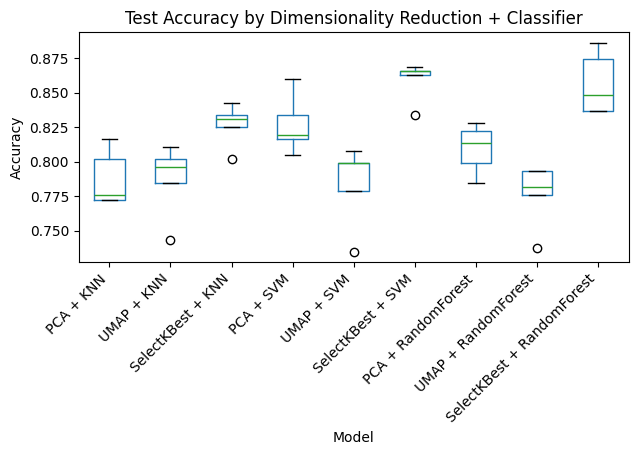

In [91]:
import matplotlib.pyplot as plt
plot_data = []
for r in results:
    for acc in r['All Accuracies']:
        plot_data.append({'Model': r['Model'], 'Accuracy': acc})
df_plot = pd.DataFrame(plot_data)

df_plot['Classifier'] = df_plot['Model'].apply(lambda x: x.split('+')[1].strip())
df_plot['DR'] = df_plot['Model'].apply(lambda x: x.split('+')[0].strip())

ordered_models = []
for clf in ['KNN', 'SVM', 'RandomForest']:
    for dr in ['PCA', 'UMAP', 'SelectKBest']:
        ordered_models.append(f"{dr} + {clf}")

# Make 'Model' a categorical column with this order
df_plot['Model'] = pd.Categorical(df_plot['Model'], categories=ordered_models, ordered=True)

plt.figure(figsize=(12, 6))
df_plot.boxplot(column='Accuracy', by='Model', grid=False) 
plt.title("Test Accuracy by Dimensionality Reduction + Classifier")
plt.suptitle("")
plt.ylabel("Accuracy")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

QUESTION 2

MISLABEL RANDOMLY FOR ALL CLASSES

In [4]:
models_noise = {
    "KNN": (KNeighborsClassifier(), {
        'clf__n_neighbors': [i for i in range(1, 40, 4)],
        'clf__metric': ['minkowski', 'euclidean', 'manhattan']
    }),
    
    
    "RandomForest": (RandomForestClassifier(), {
        'clf__n_estimators': [200, 300],
        'clf__max_depth': [20, 30, 40],
    }),
    
    "SVM": (SVC(probability=True), {
        'clf__C': [0.1, 1, 5, 10],
    }),
    
}

In [5]:
import numpy as np

def label_noise(y, noise_rate=0.1, class_labels=None):

    y = np.array(y)
    y_noisy = y.copy()
    n_samples = len(y)
    n_noisy = int(n_samples * noise_rate)
    noisy_indices = np.random.choice(n_samples, n_noisy, replace=False)

    unique_labels = np.unique(y) if class_labels is None else np.array(class_labels)

    for idx in noisy_indices:
        current_label = y[idx]
        other_labels = unique_labels[unique_labels != current_label]
        y_noisy[idx] = np.random.choice(other_labels)

    return y_noisy, noisy_indices



In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

repeats = 3

noise_rate_vals = [0.1, 0.3, 0.5, 0.7, 0.9]

test_accuracies = {name: [] for name in models_noise.keys()}
best_params_across_runs = {name: [] for name in models_noise.keys()}
conf_matrix_sums = {name: np.zeros((len(np.unique(y)), len(np.unique(y))), dtype=int) for name in models_noise.keys()}
run_metrics = {name: [] for name in models_noise.keys()}

for rep in range(repeats):
    print(f"\n Repetition {rep+1}/{repeats} ")

    all_indices = np.arange(len(X))
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, all_indices, test_size=0.2, stratify=y)

    #loop through all noise levels
    for noise_rate in noise_rate_vals:
        print(f"\nNoise Rate: {noise_rate:.1f}")

        y_train_mislab, _ = label_noise(y_train, noise_rate=noise_rate)

        for name, (clf, param_grid) in models_noise.items():
            pipe = Pipeline([
                ('scaler', StandardScaler()),
                ('clf', clf)
            ])

            grid = GridSearchCV(pipe, param_grid, cv=10, n_jobs=-1, scoring='accuracy')
            grid.fit(X_train, y_train_mislab)

            #metrics
            y_pred = grid.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            train_acc = accuracy_score(y_train_mislab, grid.predict(X_train))
            best_cv_score = grid.best_score_

            test_accuracies[name].append(acc)
            best_params_across_runs[name].append(grid.best_params_)

            cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
            conf_matrix_sums[name] += cm

            run_metrics[name].append({
                'rep': rep,
                'noise_rate': noise_rate,
                'train_acc': train_acc,
                'test_acc': acc,
                'cv_acc': best_cv_score,
                'best_params': grid.best_params_,
            })

            print(f"{name} | Acc: {acc:.4f} ")





 Repetition 1/3 

Noise Rate: 0.1
KNN | Acc: 0.7901 
RandomForest | Acc: 0.8688 
SVM | Acc: 0.8513 

Noise Rate: 0.3
KNN | Acc: 0.7726 
RandomForest | Acc: 0.8426 
SVM | Acc: 0.8222 

Noise Rate: 0.5
KNN | Acc: 0.7289 
RandomForest | Acc: 0.7901 
SVM | Acc: 0.7493 

Noise Rate: 0.7
KNN | Acc: 0.4869 
RandomForest | Acc: 0.4461 
SVM | Acc: 0.5190 

Noise Rate: 0.9
KNN | Acc: 0.1195 
RandomForest | Acc: 0.1050 
SVM | Acc: 0.0933 

 Repetition 2/3 

Noise Rate: 0.1
KNN | Acc: 0.7784 
RandomForest | Acc: 0.8426 
SVM | Acc: 0.7959 

Noise Rate: 0.3
KNN | Acc: 0.7638 
RandomForest | Acc: 0.8163 
SVM | Acc: 0.7843 

Noise Rate: 0.5
KNN | Acc: 0.6997 
RandomForest | Acc: 0.7726 
SVM | Acc: 0.6880 

Noise Rate: 0.7
KNN | Acc: 0.5306 
RandomForest | Acc: 0.4636 
SVM | Acc: 0.5656 

Noise Rate: 0.9
KNN | Acc: 0.1079 
RandomForest | Acc: 0.1195 
SVM | Acc: 0.1195 

 Repetition 3/3 

Noise Rate: 0.1
KNN | Acc: 0.7988 
RandomForest | Acc: 0.8397 
SVM | Acc: 0.8017 

Noise Rate: 0.3
KNN | Acc: 0.795

NameError: name 'models' is not defined

In [8]:
plot_data = {name: {} for name in models_noise.keys()}

for name in models_noise.keys():
    df = pd.DataFrame(run_metrics[name])
    grouped = df.groupby('noise_rate')['test_acc'].mean()

    for noise, acc in grouped.items():
        plot_data[name][noise] = acc

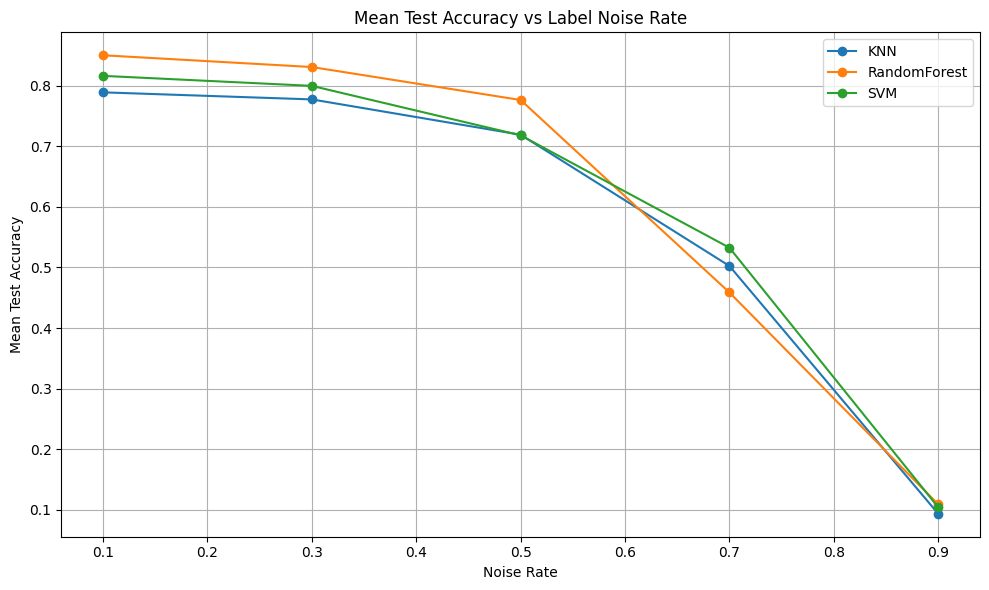

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(10, 6))

for name in models_noise.keys():
    noise_levels = sorted(plot_data[name].keys())
    mean_accuracies = [plot_data[name][n] for n in noise_levels]
    plt.plot(noise_levels, mean_accuracies, marker='o', label=name)

plt.xlabel("Noise Rate")
plt.ylabel("Mean Test Accuracy")
plt.title("Mean Test Accuracy vs Label Noise Rate")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()        

In [12]:
import pandas as pd

# Flatten run_metrics into a long-format DataFrame
plot_data = []

for model_name, runs in run_metrics.items():
    for run in runs:
        plot_data.append({
            'Model': model_name,
            'Noise Level': run['noise_rate'],
            'Test Accuracy': run['test_acc']
        })

plot_df = pd.DataFrame(plot_data)

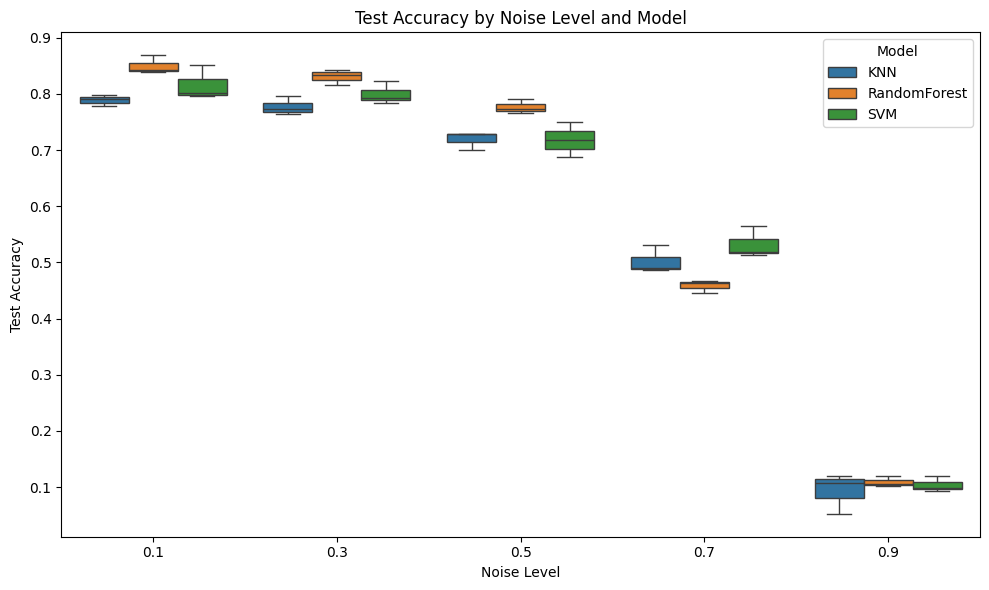

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(data=plot_df, x='Noise Level', y='Test Accuracy', hue='Model')
plt.title('Test Accuracy by Noise Level and Model')
plt.xlabel('Noise Level')
plt.ylabel('Test Accuracy')
plt.legend(title='Model')
plt.tight_layout()
plt.show()

In [17]:
def targeted_label_noise(y, source_class, target_class, noise_rate):

#source_class: class to change
#target_class: class to mislabel as
    y = np.array(y)
    y_noisy = y.copy()

    source_indices = np.where(y == source_class)[0]
    n_to_mislabel = int(len(source_indices) * noise_rate)

    noisy_indices = np.random.choice(source_indices, n_to_mislabel, replace=False)

    y_noisy[noisy_indices] = target_class

    return y_noisy, noisy_indices


In [19]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

repeats = 3

noise_rate_vals = [0.1, 0.3, 0.5, 0.7, 0.9]

test_accuracies = {name: [] for name in models_noise.keys()}
best_params_across_runs = {name: [] for name in models_noise.keys()}
conf_matrix_sums = {name: np.zeros((len(np.unique(y)), len(np.unique(y))), dtype=int) for name in models_noise.keys()}
run_metrics = {name: [] for name in models_noise.keys()}

source_class = 1
target_class = 2

for rep in range(repeats):
    print(f"\n Repetition {rep+1}/{repeats} ")

    all_indices = np.arange(len(X))
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, all_indices, test_size=0.2, stratify=y)

    #loop through all noise levels
    for noise_rate in noise_rate_vals:
        print(f"\nNoise Rate: {noise_rate:.1f}")

        y_train_mislab, _ = targeted_label_noise(y_train, source_class, target_class, noise_rate)

        for name, (clf, param_grid) in models_noise.items():
            pipe = Pipeline([
                ('scaler', StandardScaler()),
                ('clf', clf)
            ])

            grid = GridSearchCV(pipe, param_grid, cv=10, n_jobs=-1, scoring='accuracy')
            grid.fit(X_train, y_train_mislab)

            #metrics
            y_pred = grid.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            train_acc = accuracy_score(y_train_mislab, grid.predict(X_train))
            best_cv_score = grid.best_score_

            test_accuracies[name].append(acc)
            best_params_across_runs[name].append(grid.best_params_)

            cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
            conf_matrix_sums[name] += cm

            run_metrics[name].append({
                'rep': rep,
                'noise_rate': noise_rate,
                'train_acc': train_acc,
                'test_acc': acc,
                'cv_acc': best_cv_score,
                'best_params': grid.best_params_,
            })

            print(f"{name} | Acc: {acc:.4f} ")

plot_data_targ = {name: {} for name in models_noise.keys()}

for name in models_noise.keys():
    df = pd.DataFrame(run_metrics[name])
    grouped = df.groupby('noise_rate')['test_acc'].mean()

    for noise, acc in grouped.items():
        plot_data_targ[name][noise] = acc



 Repetition 1/3 

Noise Rate: 0.1
KNN | Acc: 0.8134 
RandomForest | Acc: 0.8601 
SVM | Acc: 0.8484 

Noise Rate: 0.3
KNN | Acc: 0.7843 
RandomForest | Acc: 0.8367 
SVM | Acc: 0.8192 

Noise Rate: 0.5
KNN | Acc: 0.6676 
RandomForest | Acc: 0.7055 
SVM | Acc: 0.7376 

Noise Rate: 0.7
KNN | Acc: 0.6385 
RandomForest | Acc: 0.6706 
SVM | Acc: 0.6501 

Noise Rate: 0.9
KNN | Acc: 0.6297 
RandomForest | Acc: 0.6706 
SVM | Acc: 0.6618 

 Repetition 2/3 

Noise Rate: 0.1
KNN | Acc: 0.8338 
RandomForest | Acc: 0.8834 
SVM | Acc: 0.8426 

Noise Rate: 0.3
KNN | Acc: 0.8017 
RandomForest | Acc: 0.8571 
SVM | Acc: 0.8047 

Noise Rate: 0.5
KNN | Acc: 0.6880 
RandomForest | Acc: 0.6997 
SVM | Acc: 0.6764 

Noise Rate: 0.7
KNN | Acc: 0.6472 
RandomForest | Acc: 0.6793 
SVM | Acc: 0.6531 

Noise Rate: 0.9
KNN | Acc: 0.6472 
RandomForest | Acc: 0.6910 
SVM | Acc: 0.6706 

 Repetition 3/3 

Noise Rate: 0.1
KNN | Acc: 0.7784 
RandomForest | Acc: 0.8484 
SVM | Acc: 0.8251 

Noise Rate: 0.3
KNN | Acc: 0.784

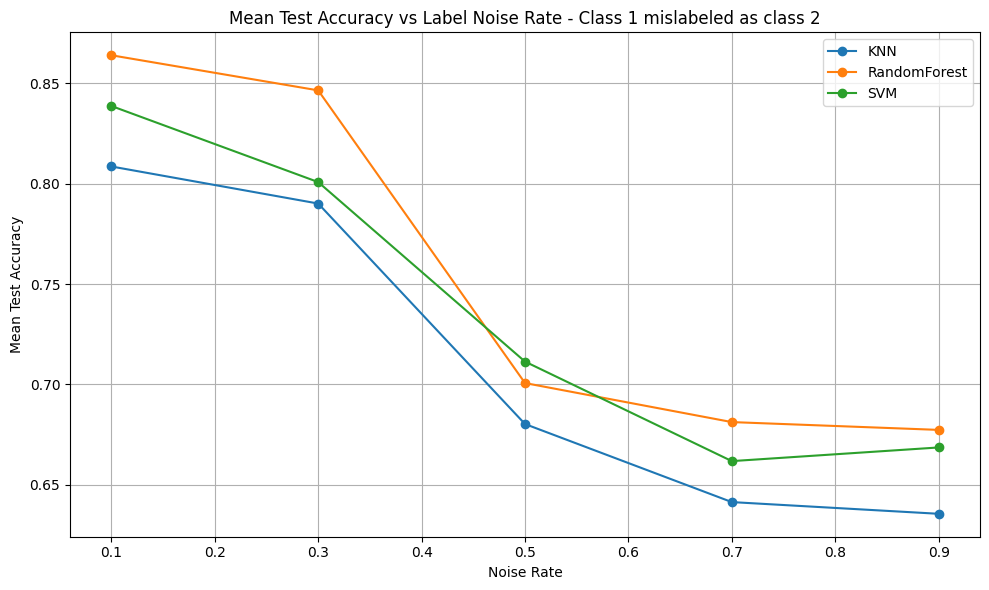

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(10, 6))

for name in models_noise.keys():
    noise_levels = sorted(plot_data_targ[name].keys())
    mean_accuracies = [plot_data_targ[name][n] for n in noise_levels]
    plt.plot(noise_levels, mean_accuracies, marker='o', label=name)

plt.xlabel("Noise Rate")
plt.ylabel("Mean Test Accuracy")
plt.title(f"Mean Test Accuracy vs Label Noise Rate - Class {source_class} mislabeled as class {target_class}")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()    

In [21]:
import pandas as pd

# Flatten run_metrics into a long-format DataFrame
plot_data = []

for model_name, runs in run_metrics.items():
    for run in runs:
        plot_data.append({
            'Model': model_name,
            'Noise Level': run['noise_rate'],
            'Test Accuracy': run['test_acc']
        })

plot_df = pd.DataFrame(plot_data)

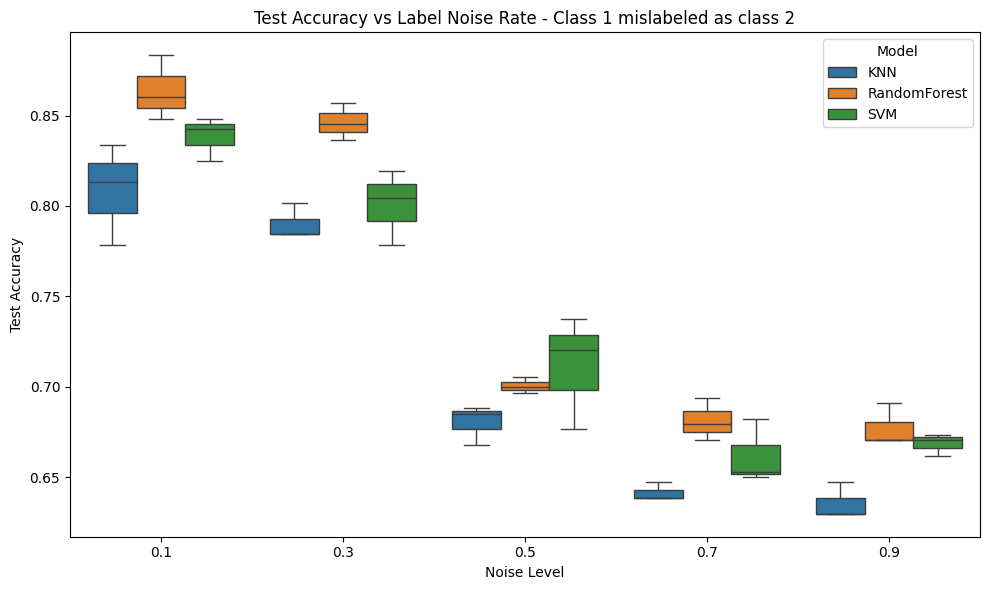

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(data=plot_df, x='Noise Level', y='Test Accuracy', hue='Model')
plt.title(f"Test Accuracy vs Label Noise Rate - Class {source_class} mislabeled as class {target_class}")
plt.xlabel('Noise Level')
plt.ylabel('Test Accuracy')
plt.legend(title='Model')
plt.tight_layout()
plt.show()

In [29]:
import numpy as np
import pandas as pd

def feature_noise(X, noise_rate=0.1, noise_std=1):
    rng = np.random.default_rng()
    if isinstance(X, pd.DataFrame):
        X_noisy = X.copy()
        feature_names = X.columns
    else:
        X = pd.DataFrame(X)
        X_noisy = X.copy()
        feature_names = X.columns

    n_samples, n_features = X_noisy.shape
    n_total = n_samples * n_features
    n_noisy = int(n_total * noise_rate)

    flat_indices = np.random.choice(n_total, n_noisy, replace=False)
    row_indices, col_indices = np.unravel_index(flat_indices, (n_samples, n_features))

    for r, c in zip(row_indices, col_indices):
        col = feature_names[c]
        scale = X[col].std()
        noise = rng.normal(loc=0.0, scale=noise_std * scale)
        X_noisy.iat[r, c] += noise

    noisy_positions = list(zip(row_indices, col_indices))

    return X_noisy, noisy_positions

In [30]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

repeats = 3

noise_rate_vals = [0.1, 0.3, 0.5, 0.7, 0.9]

test_accuracies = {name: [] for name in models_noise.keys()}
best_params_across_runs = {name: [] for name in models_noise.keys()}
conf_matrix_sums = {name: np.zeros((len(np.unique(y)), len(np.unique(y))), dtype=int) for name in models_noise.keys()}
run_metrics = {name: [] for name in models_noise.keys()}


for rep in range(repeats):
    print(f"\n Repetition {rep+1}/{repeats} ")

    all_indices = np.arange(len(X))
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, all_indices, test_size=0.2, stratify=y)

    #loop through all noise levels
    for noise_rate in noise_rate_vals:
        print(f"\nNoise Rate: {noise_rate:.1f}")

        X_train_noise, _ = feature_noise(X_train, noise_rate, noise_std=15.0)

        for name, (clf, param_grid) in models_noise.items():
            pipe = Pipeline([
                ('scaler', StandardScaler()),
                ('clf', clf)
            ])

            grid = GridSearchCV(pipe, param_grid, cv=10, n_jobs=-1, scoring='accuracy')
            grid.fit(X_train_noise, y_train)

            #metrics
            y_pred = grid.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            train_acc = accuracy_score(y_train, grid.predict(X_train_noise))
            best_cv_score = grid.best_score_

            test_accuracies[name].append(acc)
            best_params_across_runs[name].append(grid.best_params_)

            cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
            conf_matrix_sums[name] += cm

            run_metrics[name].append({
                'rep': rep,
                'noise_rate': noise_rate,
                'train_acc': train_acc,
                'test_acc': acc,
                'cv_acc': best_cv_score,
                'best_params': grid.best_params_,
            })

            print(f"{name} | Acc: {acc:.4f} ")

plot_data_feat = {name: {} for name in models_noise.keys()}

for name in models_noise.keys():
    df = pd.DataFrame(run_metrics[name])
    grouped = df.groupby('noise_rate')['test_acc'].mean()

    for noise, acc in grouped.items():
        plot_data_feat[name][noise] = acc



 Repetition 1/3 

Noise Rate: 0.1
KNN | Acc: 0.5248 
RandomForest | Acc: 0.8484 
SVM | Acc: 0.4956 

Noise Rate: 0.3
KNN | Acc: 0.3965 
RandomForest | Acc: 0.8017 
SVM | Acc: 0.3003 

Noise Rate: 0.5
KNN | Acc: 0.2128 
RandomForest | Acc: 0.7318 
SVM | Acc: 0.2128 

Noise Rate: 0.7
KNN | Acc: 0.2653 
RandomForest | Acc: 0.5015 
SVM | Acc: 0.2128 

Noise Rate: 0.9
KNN | Acc: 0.1545 
RandomForest | Acc: 0.2507 
SVM | Acc: 0.2128 

 Repetition 2/3 

Noise Rate: 0.1
KNN | Acc: 0.5569 
RandomForest | Acc: 0.8309 
SVM | Acc: 0.4169 

Noise Rate: 0.3
KNN | Acc: 0.3003 
RandomForest | Acc: 0.7988 
SVM | Acc: 0.2187 

Noise Rate: 0.5
KNN | Acc: 0.1603 
RandomForest | Acc: 0.7085 
SVM | Acc: 0.2128 

Noise Rate: 0.7
KNN | Acc: 0.2303 
RandomForest | Acc: 0.5510 
SVM | Acc: 0.2128 

Noise Rate: 0.9
KNN | Acc: 0.2128 
RandomForest | Acc: 0.2128 
SVM | Acc: 0.2128 

 Repetition 3/3 

Noise Rate: 0.1
KNN | Acc: 0.4519 
RandomForest | Acc: 0.8571 
SVM | Acc: 0.6064 

Noise Rate: 0.3
KNN | Acc: 0.381

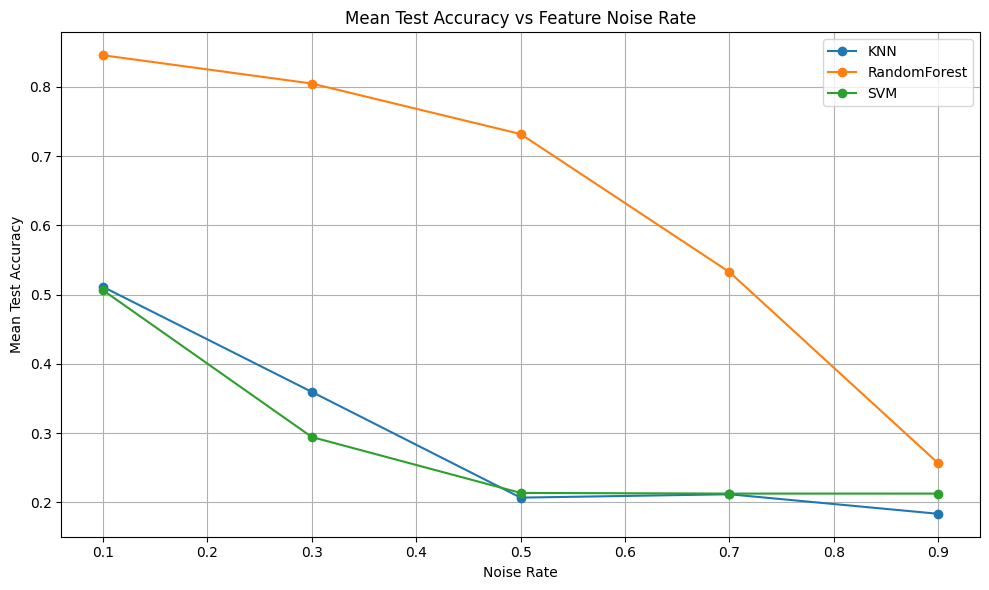

In [31]:

plt.figure(figsize=(10, 6))

for name in models_noise.keys():
    noise_levels = sorted(plot_data_feat[name].keys())
    mean_accuracies = [plot_data_feat[name][n] for n in noise_levels]
    plt.plot(noise_levels, mean_accuracies, marker='o', label=name)

plt.xlabel("Noise Rate")
plt.ylabel("Mean Test Accuracy")
plt.title("Mean Test Accuracy vs Feature Noise Rate")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()    

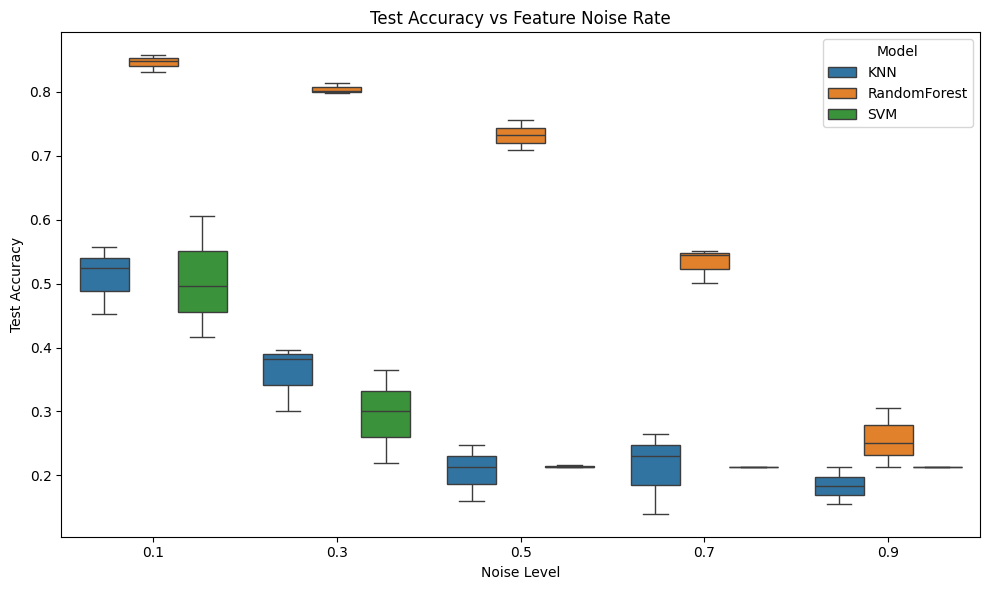

In [32]:
import pandas as pd

# Flatten run_metrics into a long-format DataFrame
plot_data = []

for model_name, runs in run_metrics.items():
    for run in runs:
        plot_data.append({
            'Model': model_name,
            'Noise Level': run['noise_rate'],
            'Test Accuracy': run['test_acc']
        })

plot_df = pd.DataFrame(plot_data)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(data=plot_df, x='Noise Level', y='Test Accuracy', hue='Model')
plt.title(f"Test Accuracy vs Feature Noise Rate")
plt.xlabel('Noise Level')
plt.ylabel('Test Accuracy')
plt.legend(title='Model')
plt.tight_layout()
plt.show()

In [34]:
import numpy as np
import pandas as pd

def feature_noise_to_class(X, y, target_class, noise_rate=0.1, noise_std=1.0, scale_by_feature=True):
    rng = np.random.default_rng()

    if isinstance(X, pd.DataFrame):
        X_noisy = X.copy()
        feature_names = X.columns
    else:
        X = pd.DataFrame(X)
        X_noisy = X.copy()
        feature_names = X.columns

    y = np.array(y)
    target_indices = np.where(y == target_class)[0]
    n_samples_target = len(target_indices)
    n_features = X.shape[1]

    n_to_corrupt = int(n_samples_target * n_features * noise_rate)

    if n_to_corrupt == 0:
        return X_noisy, []

    flat_indices = rng.choice(n_samples_target * n_features, n_to_corrupt, replace=False)
    row_offsets, col_indices = np.unravel_index(flat_indices, (n_samples_target, n_features))
    row_indices = target_indices[row_offsets]

    for r, c in zip(row_indices, col_indices):
        col = feature_names[c]
        scale = X[col].std() if scale_by_feature else 1.0
        noise = rng.normal(loc=0.0, scale=noise_std * scale)
        X_noisy.iat[r, c] += noise

    noisy_positions = list(zip(row_indices, col_indices))
    return X_noisy, noisy_positions


In [38]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

# Repetition count for stability testing
repeats = 3

# Extended noise levels
noise_rate_vals = [0.1, 0.3, 0.5, 0.7, 0.9]

# Initialize result containers
test_accuracies = {name: [] for name in models_noise.keys()}
best_params_across_runs = {name: [] for name in models_noise.keys()}
conf_matrix_sums = {name: np.zeros((len(np.unique(y)), len(np.unique(y))), dtype=int) for name in models_noise.keys()}
run_metrics = {name: [] for name in models_noise.keys()}

target_class = 1

for rep in range(repeats):
    print(f"\n Repetition {rep+1}/{repeats} ")

    all_indices = np.arange(len(X))
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, all_indices, test_size=0.2, stratify=y)

    #loop through all noise levels
    for noise_rate in noise_rate_vals:
        print(f"\nNoise Rate: {noise_rate:.1f}")

        X_train_noise, _ = feature_noise_to_class(X_train, y_train, target_class, noise_rate=noise_rate, noise_std=15)

        for name, (clf, param_grid) in models_noise.items():
            pipe = Pipeline([
                ('scaler', StandardScaler()),
                ('clf', clf)
            ])

            grid = GridSearchCV(pipe, param_grid, cv=10, n_jobs=-1, scoring='accuracy')
            grid.fit(X_train_noise, y_train)

            #metrics
            y_pred = grid.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            train_acc = accuracy_score(y_train, grid.predict(X_train_noise))
            best_cv_score = grid.best_score_

            test_accuracies[name].append(acc)
            best_params_across_runs[name].append(grid.best_params_)

            cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
            conf_matrix_sums[name] += cm

            run_metrics[name].append({
                'rep': rep,
                'noise_rate': noise_rate,
                'train_acc': train_acc,
                'test_acc': acc,
                'cv_acc': best_cv_score,
                'best_params': grid.best_params_,
            })

            print(f"{name} | Acc: {acc:.4f} ")


plot_data_feat_targ = {name: {} for name in models_noise.keys()}

for name in models_noise.keys():
    df = pd.DataFrame(run_metrics[name])
    grouped = df.groupby('noise_rate')['test_acc'].mean()

    for noise, acc in grouped.items():
        plot_data_feat_targ[name][noise] = acc
           


 Repetition 1/3 

Noise Rate: 0.1
KNN | Acc: 0.6327 
RandomForest | Acc: 0.8222 
SVM | Acc: 0.6356 

Noise Rate: 0.3
KNN | Acc: 0.6385 
RandomForest | Acc: 0.8134 
SVM | Acc: 0.6472 

Noise Rate: 0.5
KNN | Acc: 0.6239 
RandomForest | Acc: 0.6531 
SVM | Acc: 0.6443 

Noise Rate: 0.7
KNN | Acc: 0.6385 
RandomForest | Acc: 0.6706 
SVM | Acc: 0.6414 

Noise Rate: 0.9
KNN | Acc: 0.6356 
RandomForest | Acc: 0.6618 
SVM | Acc: 0.6443 

 Repetition 2/3 

Noise Rate: 0.1
KNN | Acc: 0.6531 
RandomForest | Acc: 0.8542 
SVM | Acc: 0.6501 

Noise Rate: 0.3
KNN | Acc: 0.6531 
RandomForest | Acc: 0.8542 
SVM | Acc: 0.6560 

Noise Rate: 0.5
KNN | Acc: 0.6443 
RandomForest | Acc: 0.6968 
SVM | Acc: 0.6589 

Noise Rate: 0.7
KNN | Acc: 0.6327 
RandomForest | Acc: 0.6851 
SVM | Acc: 0.6618 

Noise Rate: 0.9
KNN | Acc: 0.6356 
RandomForest | Acc: 0.6793 
SVM | Acc: 0.6501 

 Repetition 3/3 

Noise Rate: 0.1
KNN | Acc: 0.6268 
RandomForest | Acc: 0.8630 
SVM | Acc: 0.6618 

Noise Rate: 0.3
KNN | Acc: 0.626

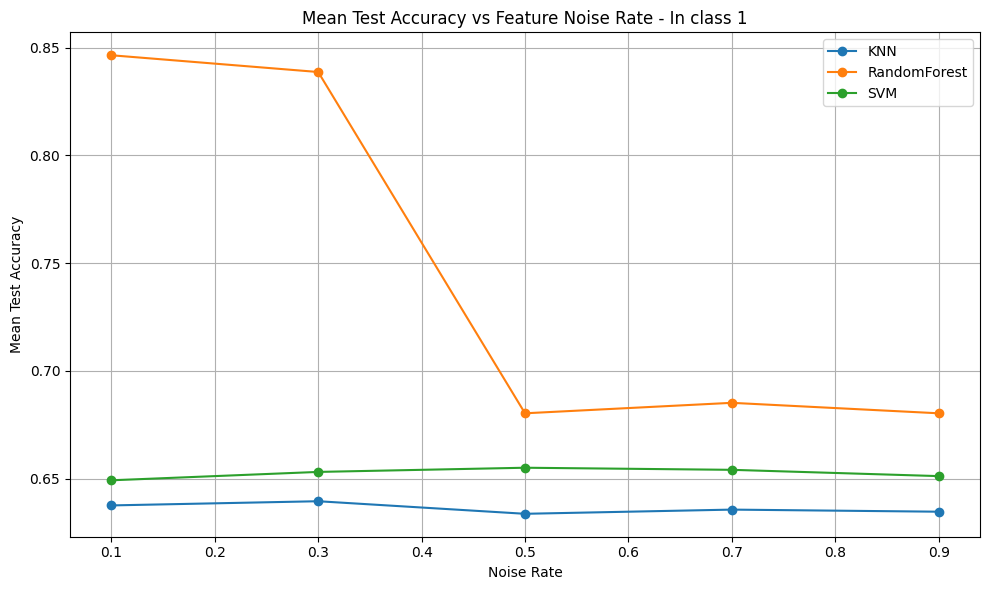

In [39]:
plt.figure(figsize=(10, 6))

for name in models_noise.keys():
    noise_levels = sorted(plot_data_feat_targ[name].keys())
    mean_accuracies = [plot_data_feat_targ[name][n] for n in noise_levels]
    plt.plot(noise_levels, mean_accuracies, marker='o', label=name)

plt.xlabel("Noise Rate")
plt.ylabel("Mean Test Accuracy")
plt.title(f"Mean Test Accuracy vs Feature Noise Rate - In class {target_class}")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show() 

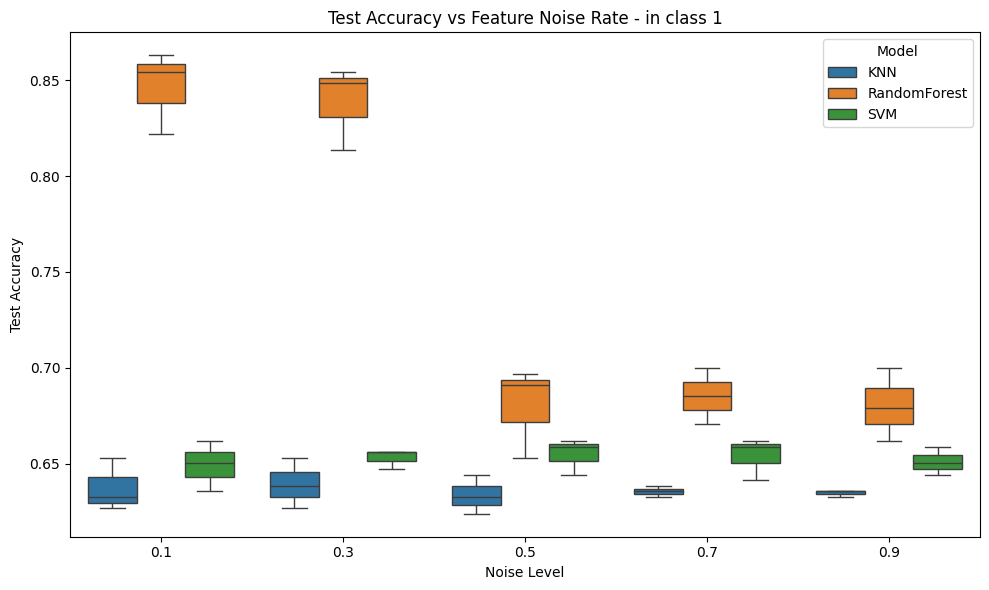

In [40]:
import pandas as pd

# Flatten run_metrics into a long-format DataFrame
plot_data = []

for model_name, runs in run_metrics.items():
    for run in runs:
        plot_data.append({
            'Model': model_name,
            'Noise Level': run['noise_rate'],
            'Test Accuracy': run['test_acc']
        })

plot_df = pd.DataFrame(plot_data)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(data=plot_df, x='Noise Level', y='Test Accuracy', hue='Model')
plt.title(f"Test Accuracy vs Feature Noise Rate - in class {target_class}")
plt.xlabel('Noise Level')
plt.ylabel('Test Accuracy')
plt.legend(title='Model')
plt.tight_layout()
plt.show()

QUESTION 3a

In [47]:
models_merge = {
    "KNN": (KNeighborsClassifier(), {
        'clf__n_neighbors': [i for i in range(1, 40, 4)],
        'clf__metric': ['minkowski', 'euclidean', 'manhattan']
    }),
    
    
    "RandomForest": (RandomForestClassifier(), {
        'clf__n_estimators': [200, 300],
        'clf__max_depth': [20, 30, 40],
    }),
    
    "SVM": (SVC(probability=True), {
        'clf__C': [0.1, 1, 5, 10],
    }),
    
}

In [48]:
import numpy as np

def merge_classes(y, from_class, to_class):

    y = np.array(y)
    y_merged = y.copy()
    y_merged[y_merged == from_class] = to_class
    return y_merged

In [52]:
y_merged_simple = merge_classes(y, from_class=1, to_class=2)

In [53]:
#how many train/test splits to run
repeats = 5

#declare variables to store important information: test acc, best params and confusion matrix values
test_accuracies = {name: [] for name in models_merge.keys()}
best_params_across_runs = {name: [] for name in models_merge.keys()}
conf_matrix_sums = {name: np.zeros((len(np.unique(y_merged_simple)), len(np.unique(y_merged_simple))), dtype=int) for name in models_merge.keys()}
run_metrics = {name: [] for name in models_merge.keys()}

#Outer loop for test/train splits
for i in range(repeats):
    print(f"\nRepetition {i+1}/{repeats}")
    
    #split data with stratified sampling into 20% test and 80% train
    all_indices = np.arange(len(X))
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y_merged_simple, all_indices, test_size=0.2, stratify=y_merged_simple)
    
    #Inner loop with 10-fold CV
    for name, (clf, param_grid) in models_merge.items():

        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', clf)
        ])
        
        grid = GridSearchCV(pipe, param_grid, cv=10, n_jobs=-1, scoring='accuracy')
        grid.fit(X_train, y_train)

        #compute metrics
        y_pred = grid.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        train_acc = accuracy_score(y_train, grid.predict(X_train))
        best_cv_score = grid.best_score_

        #store metrics
        test_accuracies[name].append(acc)
        best_params_across_runs[name].append(grid.best_params_)

        #update confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        conf_matrix_sums[name] += cm

        print(f"{name}: {acc:.4f}")


Repetition 1/5
KNN: 0.8222
RandomForest: 0.8688
SVM: 0.8717

Repetition 2/5
KNN: 0.8076
RandomForest: 0.8601
SVM: 0.8513

Repetition 3/5
KNN: 0.8338
RandomForest: 0.9038
SVM: 0.8659

Repetition 4/5
KNN: 0.7930
RandomForest: 0.8601
SVM: 0.8222

Repetition 5/5
KNN: 0.8280
RandomForest: 0.8980
SVM: 0.8805


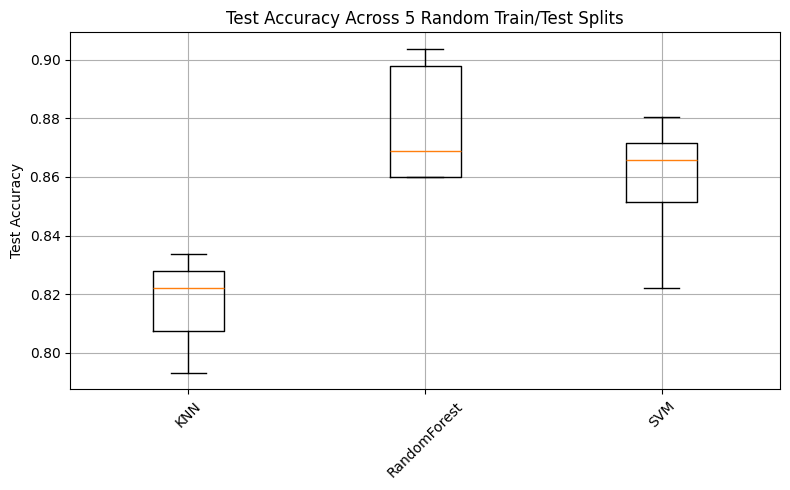

In [54]:
plt.figure(figsize=(8, 5))
plt.boxplot([test_accuracies[name] for name in models_merge.keys()], labels=models_merge.keys())

plt.ylabel('Test Accuracy')
plt.title('Test Accuracy Across 5 Random Train/Test Splits')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

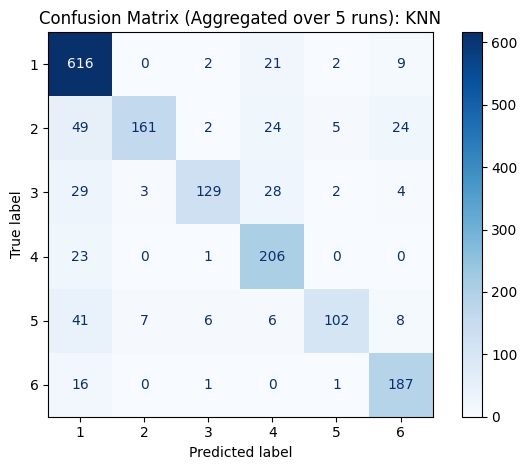

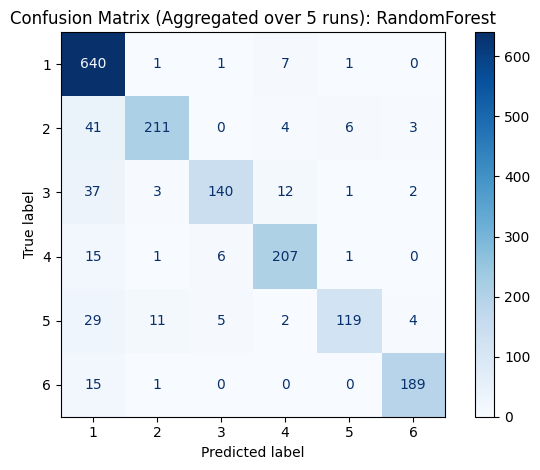

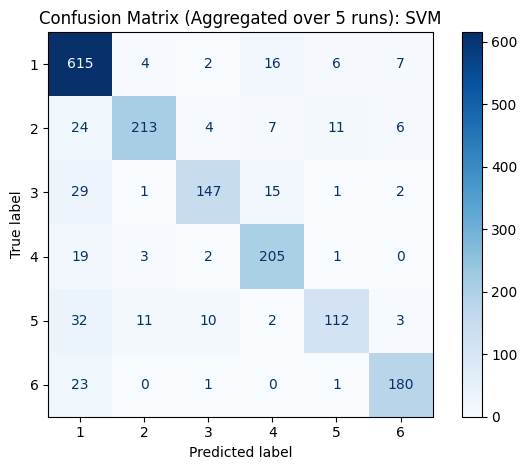

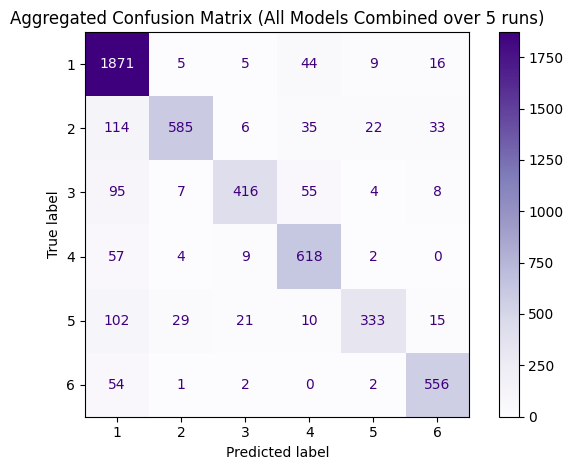

In [56]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

for name, cm_sum in conf_matrix_sums.items():
    num_classes = cm_sum.shape[0]
    class_labels = [f'{i+1}' for i in range(num_classes)]

    disp = ConfusionMatrixDisplay(confusion_matrix=cm_sum, display_labels=class_labels)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix (Aggregated over {repeats} runs): {name}')
    plt.tight_layout()
    plt.show()

total_cm = sum(conf_matrix_sums.values())

num_classes = total_cm.shape[0]
class_labels = [f'{i+1}' for i in range(num_classes)]

disp = ConfusionMatrixDisplay(confusion_matrix=total_cm, display_labels=class_labels)
disp.plot(cmap='Purples')
plt.title(f'Aggregated Confusion Matrix (All Models Combined over {repeats} runs)')
plt.tight_layout()
plt.show()

In [109]:
y_merged_difficult = merge_classes(y, from_class=7, to_class=5)
y_merged_difficult = merge_classes(y_merged_difficult, from_class=5, to_class=1)
print(np.unique(y_merged_difficult))

[1 2 3 4 6]


In [112]:
#how many train/test splits to run
repeats = 5

#declare variables to store important information: test acc, best params and confusion matrix values
test_accuracies = {name: [] for name in models.keys()}
best_params_across_runs = {name: [] for name in models.keys()}
conf_matrix_sums = {name: np.zeros((len(np.unique(y_merged_difficult)), len(np.unique(y_merged_difficult))), dtype=int) for name in models.keys()}
run_metrics = {name: [] for name in models.keys()}

#Outer loop for test/train splits
for i in range(repeats):
    print(f"\nRepetition {i+1}/{repeats}")
    
    #split data with stratified sampling into 20% test and 80% train
    all_indices = np.arange(len(X_scaled))
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X_scaled, y_merged_difficult, all_indices, test_size=0.2, stratify=y_merged_difficult)
    
    #Inner loop with 10-fold CV
    for name, (clf, param_grid) in models.items():

        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', clf)
        ])
        
        grid = GridSearchCV(pipe, param_grid, cv=10, n_jobs=-1, scoring='accuracy')
        grid.fit(X_train, y_train)

        #compute metrics
        y_pred = grid.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        train_acc = accuracy_score(y_train, grid.predict(X_train))
        best_cv_score = grid.best_score_

        #store metrics
        test_accuracies[name].append(acc)
        best_params_across_runs[name].append(grid.best_params_)

        #update confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        conf_matrix_sums[name] += cm

        print(f"{name}: {acc:.4f}")


Repetition 1/5
KNN: 0.8017
LDA: 0.8134
LogReg: 0.8163
RandomForest: 0.8397
SVM: 0.8571
MLP: 0.8134

Repetition 2/5
KNN: 0.8017
LDA: 0.7813
LogReg: 0.7872
RandomForest: 0.8367
SVM: 0.8338
MLP: 0.7930

Repetition 3/5
KNN: 0.7668
LDA: 0.7638
LogReg: 0.7813
RandomForest: 0.8105
SVM: 0.8338
MLP: 0.7872

Repetition 4/5
KNN: 0.7901
LDA: 0.7726
LogReg: 0.8017
RandomForest: 0.8192
SVM: 0.8222
MLP: 0.7988

Repetition 5/5
KNN: 0.7638
LDA: 0.8076
LogReg: 0.7843
RandomForest: 0.8280
SVM: 0.8367
MLP: 0.8076


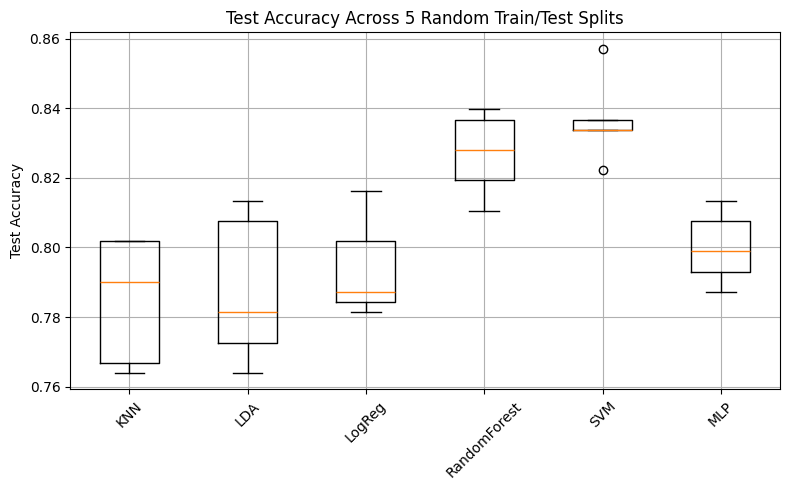

In [113]:
plt.figure(figsize=(8, 5))
plt.boxplot([test_accuracies[name] for name in models.keys()], labels=models.keys())

plt.ylabel('Test Accuracy')
plt.title('Test Accuracy Across 5 Random Train/Test Splits')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

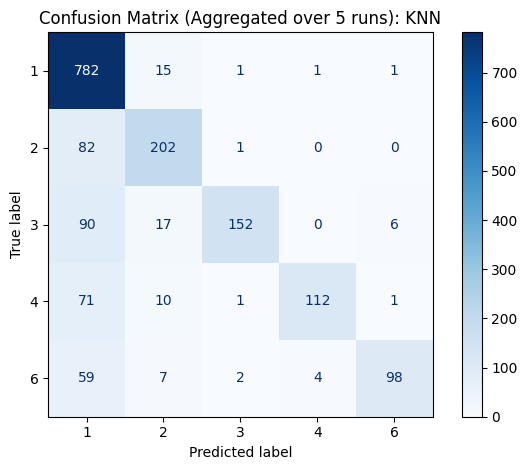

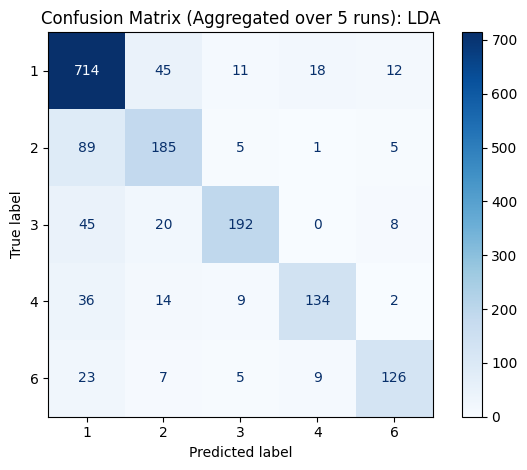

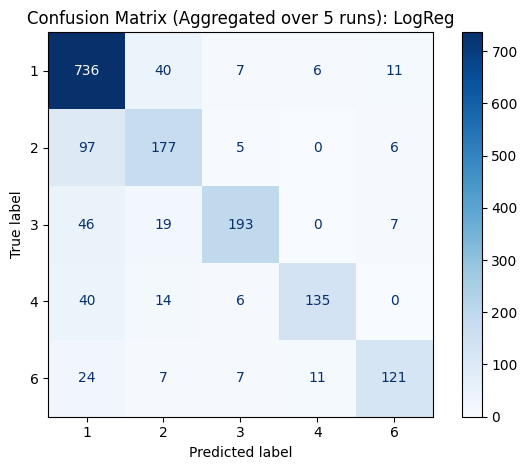

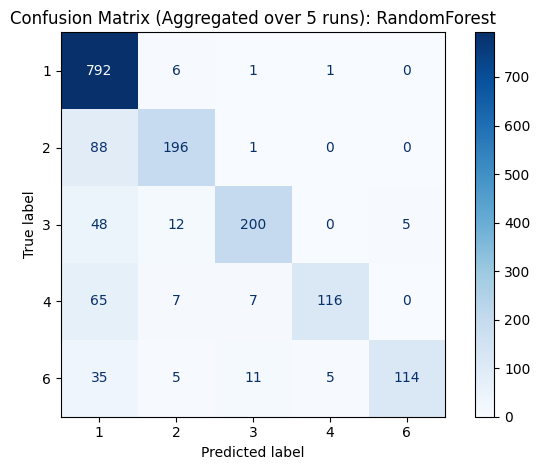

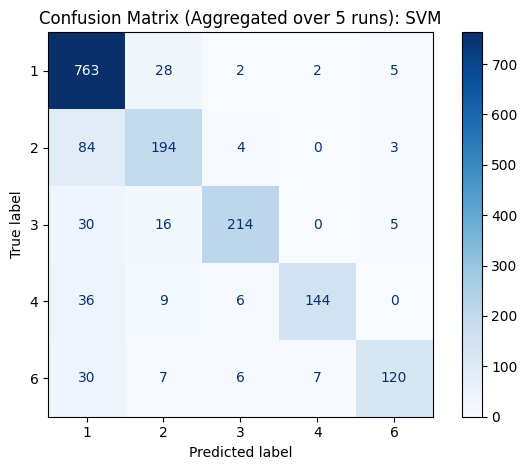

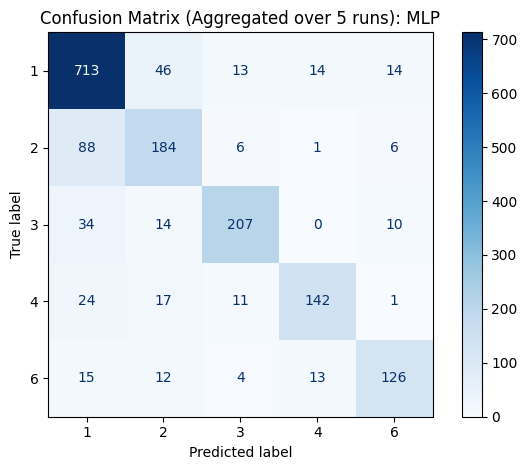

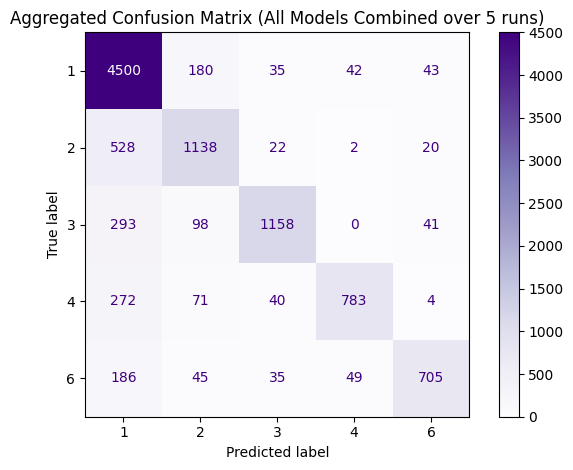

In [116]:
for name, cm_sum in conf_matrix_sums.items():
    num_classes = cm_sum.shape[0]
    class_labels = [f'{i+1}' for i in range(num_classes)]
    class_labels = np.unique(y_merged_difficult)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm_sum, display_labels=class_labels)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix (Aggregated over {repeats} runs): {name}')
    plt.tight_layout()
    plt.show()

total_cm = sum(conf_matrix_sums.values())

num_classes = total_cm.shape[0]
class_labels = [f'{i+1}' for i in range(num_classes)]
class_labels = np.unique(y_merged_difficult)

disp = ConfusionMatrixDisplay(confusion_matrix=total_cm, display_labels=class_labels)
disp.plot(cmap='Purples')
plt.title(f'Aggregated Confusion Matrix (All Models Combined over {repeats} runs)')
plt.tight_layout()
plt.show()